---
# <div align="center"><font color='black'>  </font></div>
# <div align="center"><font color='black'> COSC 2673 | Machine Learning  </font></div>
## <div align="center"> <font color='black'> Assignment 02: S3712611_Minh Hoang Nguyen, s3828276_Ngoc Vy Le </font></div>
---

# **Notebook Summary**

- This notebook presents our investigation and results for the traffic sign classification task requried in Project 1.


- The 2 dataset that was used in this notebook are the modified *Belgium Traffic Sign Recognition dataset* and the *Australian Traffic Sign dataset*, which was specifically collected for the purpose of testing models performance (the 2 dataset will be provided along with this notebook).

- For convinience sake, this notebook will only contain step by step observations/actions/reasons for parameters tuning; it will only discuss briefly on testing performance. Full evaluation of these models can be found in the 5 pages report attracted with this submission. 

`Note: This notebook is requried to be run on Google Colab as the code was designed to fit this specific platform.`




# **Importing Library**

In [2]:
!pip install -q -U keras-tuner
!pip install tensorflow-hub
!pip install split-folders


     |████████████████████████████████| 133 kB 10.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import cv2

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from keras import layers, Input
from keras.layers import InputLayer
from keras.layers.core import Dense, Flatten
from keras.models import Sequential, Model
import tensorflow_hub as hub
import keras_tuner as kt

import matplotlib.image as mpimg

from PIL import Image
import os
import glob


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns

import shutil
import splitfolders

tf.__version__

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')      # Link to google drive so later can save the model

Mounted at /content/gdrive


In [5]:
# Before using the data need to upload on to drive
# This file will be deleted at the end of the session
# Go to file on left hand side of the screen then upload file (Can upload the file to root = easier access)
# File extracted will be saved in content folder 
from zipfile import ZipFile
file_name = '/trafficsigns_dataset.zip'
independent_file_name = '/independent_data.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

with ZipFile(independent_file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done
Done


# **1. Data Preparation**


## 1.1 **Image Visualization**


In [6]:
# Making sure that we have the correct dataset
# Randomly visualizing 5 images from a folder
def image_visualizer(test_folder):
  plt.figure(figsize=(20,20))
  for i in range(5):                                                    # Randomly loaded 5 images
      file = random.choice(os.listdir(test_folder))
      image_path= os.path.join(test_folder, file)
      img=mpimg.imread(image_path)
      ax=plt.subplot(1,5,i+1)
      ax.title.set_text(file)
      plt.imshow(img, cmap = 'gray')

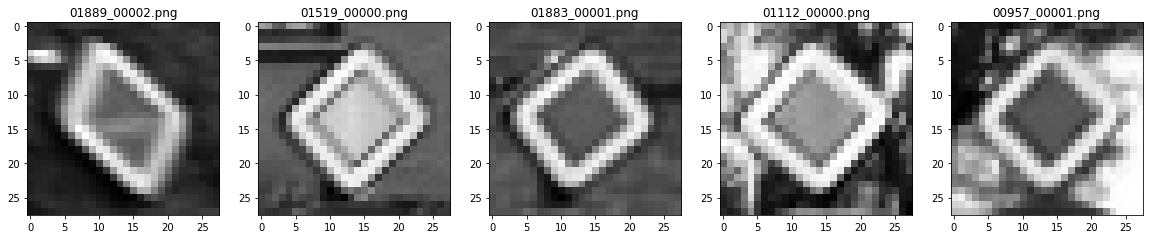

In [7]:
folder_path=r'/content/trafficsigns_dataset/diamond/rightofway'
image_visualizer(folder_path)


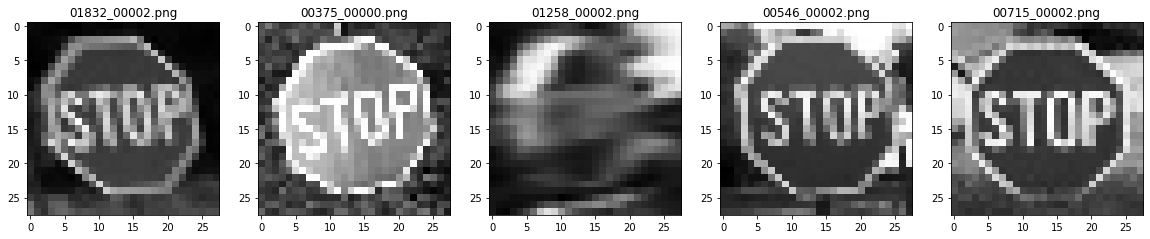

In [8]:
folder_path=r'/content/trafficsigns_dataset/hex/stop'
image_visualizer(folder_path)


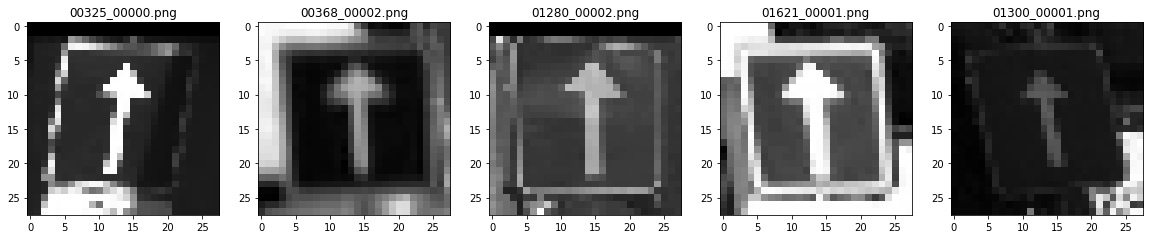

In [9]:
folder_path=r'/content/trafficsigns_dataset/square/continue'
image_visualizer(folder_path)


## 1.2 **Split data into Train, Val, Test Folder**

In [10]:
def split_data(ratio, first_run):
    """
    This function is used to create a new folder that split all entries into train, validation and test set
    
    """
    if first_run is False:
      # Removing existing folder
      shutil.rmtree(r'./train_test')      
  
    # create train test folder
    splitfolders.ratio('trafficsigns_dataset', output="train_test", ratio = ratio, seed=123)
    
    shapes = ['diamond', 'hex', 'round', 'square', 'triangle']
    diamond =["rightofway"]
    hex_ = [ 'stop']
    round_ = ['bicycle', 'limitedtraffic', 'noentry', 'noparking', 'roundabout', 'speed', 'trafficdirective', 'traveldirection']
    square = ['continue', 'crossing', 'laneend', 'parking']
    triangle = ['giveway', 'warning']
    
    # split data into train, test based on shape
    for shape in shapes:
        src = 'trafficsigns_dataset/' + shape
        dest = 'split/' + shape 
        splitfolders.ratio(src, output=dest, ratio=ratio, seed=123)
   
    # move train, set into a new folder
    shutil.move('./split/diamond/val/rightofway', './train_test/val/diamond/rightofway')
    shutil.move('./split/diamond/train/rightofway', './train_test/train/diamond/rightofway')
    shutil.move('./split/diamond/test/rightofway', './train_test/test/diamond/rightofway')
                  
    shutil.move('./split/hex/val/stop', './train_test/val/hex/stop')
    shutil.move('./split/hex/train/stop', './train_test/train/hex/stop')
    shutil.move('./split/hex/test/stop', './train_test/test/hex/stop')
            
           
    for i in round_:
        path_src = './split/round/val/' + i
        path_dest = './train_test/val/round/' + i
        shutil.move(path_src, path_dest)

        path_src = './split/round/train/' + i
        path_dest = './train_test/train/round/' + i
        shutil.move(path_src, path_dest)
        
        path_src = './split/round/test/' + i
        path_dest = './train_test/test/round/' + i
        shutil.move(path_src, path_dest)
              
    for i in square:
        path_src = './split/square/val/' + i
        path_dest = './train_test/val/square/' + i
        shutil.move(path_src,path_dest)

        path_src = './split/square/train/' + i
        path_dest = './train_test/train/square/' + i
        shutil.move(path_src, path_dest)
        
        path_src = './split/square/test/' + i
        path_dest = './train_test/test/square/' + i
        shutil.move(path_src, path_dest)
         
    for i in triangle:
        path_src = './split/triangle/val/' + i
        path_dest = './train_test/val/triangle/' + i
        shutil.move(path_src,path_dest)

        path_src = './split/triangle/train/' + i
        path_dest = './train_test/train/triangle/' + i
        shutil.move(path_src, path_dest)  
        
        path_src = './split/triangle/test/' + i
        path_dest = './train_test/test/triangle/' + i
        shutil.move(path_src, path_dest)
        
        
    # remove split folder since it is empty 
    shutil.rmtree(r'./split')      


In [11]:
split_data(ratio = (0.6, 0.2, 0.2), first_run = True)  # Set parameter to True if it is the first time running this notebook     

Copying files: 0 files [00:00, ? files/s]
Copying files: 282 files [00:00, 1686.48 files/s]
Copying files: 43 files [00:00, 2322.76 files/s]
Copying files: 1760 files [00:00, 2362.59 files/s]
Copying files: 688 files [00:00, 1663.98 files/s]
Copying files: 926 files [00:00, 2487.94 files/s]


## 1.3 **Creating Image Path Dataframe**

Data will be stored in a dataframe which has image path, shape and type as columns.

In [12]:
def file_path_into_dataframe(filepath):
  image_list = []
  if filepath == './independent_data/*/*/*.png':
        for filepath in glob.glob(filepath, recursive=True):
          sign_shape = filepath.split('/')[2]
          sign_type = filepath.split('/')[3]
          image_list.append((filepath, sign_shape, sign_type ))
  else:
    for filepath in glob.glob(filepath, recursive=True):
        sign_shape = filepath.split('/')[3]
        sign_type = filepath.split('/')[4]
        image_list.append((filepath, sign_shape, sign_type ))
      
      
  # create a dataframe
  data = pd.DataFrame(data= image_list, columns=["image_path", 'sign_shape','sign_type'])
  # inspecting the dataframe
  return data

In [13]:
train_data = file_path_into_dataframe('./train_test/train/*/*/*.png')
val_data = file_path_into_dataframe('./train_test/val/*/*/*.png')
test_data = file_path_into_dataframe('./train_test/test/*/*/*.png')
train_data.head() 

,image_path,sign_shape,sign_type
0,./train_test/train/diamond/rightofway/00063_00...,diamond,rightofway
1,./train_test/train/diamond/rightofway/01935_00...,diamond,rightofway
2,./train_test/train/diamond/rightofway/00042_00...,diamond,rightofway
3,./train_test/train/diamond/rightofway/00044_00...,diamond,rightofway
4,./train_test/train/diamond/rightofway/01514_00...,diamond,rightofway


In [14]:
# data shape
print("The shape of training data is", train_data.shape)
print("The shape of validating data is", val_data.shape)
print("The shape of testing data is", test_data.shape)


The shape of training data is (2214, 3)
The shape of validating data is (735, 3)
The shape of testing data is (750, 3)


In [15]:
print("numbers of shape:", len(train_data.sign_shape.unique()))
train_data.sign_shape.unique()

numbers of shape: 5


array(['diamond', 'round', 'triangle', 'square', 'hex'], dtype=object)

In [16]:
print("numbers of type:", len(train_data.sign_type.unique()))
train_data.sign_type.unique()

numbers of type: 16


array(['rightofway', 'roundabout', 'bicycle', 'noparking',
       'limitedtraffic', 'speed', 'trafficdirective', 'traveldirection',
       'noentry', 'warning', 'giveway', 'continue', 'crossing', 'parking',
       'laneend', 'stop'], dtype=object)

## 1.4 **Data Distribution**

In [17]:
def plot_distribution(data, dataset_column):
  plt.figure(figsize=(20,10))
  for i in range(1, len(data.columns)):
      plt.subplot(2,1,i)
      data.iloc[:, i].sort_values().astype(str).hist()
      txt = "distribution of " + data.columns[i] + " in " + dataset_column +" dataset"
      plt.title(txt)


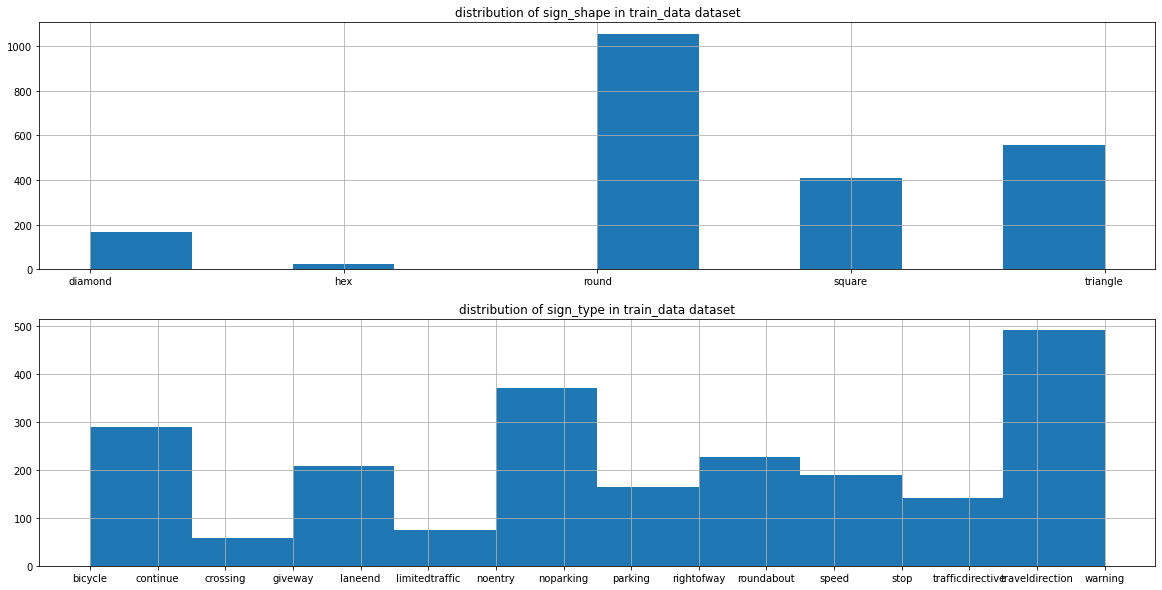

In [18]:
plot_distribution(train_data, "train_data")

**<u>Observation</u>:**

 * Shape data has 5 classes, while, sign data has 16 classes.
 * Class imbalance problem in both shape and type data. <br>



## 1.5 **Labels encoding**

Using label encoder from sklearn to transform label into integer.

In [19]:
def label_encoder(dataframe):
  labelEncoder = LabelEncoder()
  if "sign_shape" in dataframe:
    dataframe.sign_shape = labelEncoder.fit_transform(dataframe.sign_shape)
  if "sign_type" in dataframe:
    dataframe.sign_type = labelEncoder.fit_transform(dataframe.sign_type)

# inspecting the changes
label_encoder(train_data)
train_data.head()

,image_path,sign_shape,sign_type
0,./train_test/train/diamond/rightofway/00063_00...,0,9
1,./train_test/train/diamond/rightofway/01935_00...,0,9
2,./train_test/train/diamond/rightofway/00042_00...,0,9
3,./train_test/train/diamond/rightofway/00044_00...,0,9
4,./train_test/train/diamond/rightofway/01514_00...,0,9


In [20]:
label_encoder(val_data)
label_encoder(test_data)

## 1.6 **Data Augmentation**

In [21]:
def create_augmented_folder(first_run):
  if first_run is False:
  # Use these two code to remove these augmented folders if no longer need
    shutil.rmtree(r'./augmented_shape')      
    shutil.rmtree(r'./augmented_type') 

  src = '/content/train_test/train'

  # create folder for shape
  dest1 = '/content/augmented_shape/train'

  # create folder for type
  dest2 = '/content/augmented_type/train'

  # copy
  shutil.copytree(src, dest1)
  shutil.copytree(src, dest2)



In [22]:
create_augmented_folder(first_run = True) # Set parameter to True if it is the first time running this notebook     

In [23]:
def img_augmentation(folder_path, limit):
    image_list = []
    path = folder_path + '/*.png'
    print(path)
    
    for image in glob.glob(path, recursive=True):
        # read image
        img =  mpimg.imread(image )
        img_arr = img_to_array(img)
        img_arr = img_arr.reshape((1,) + img_arr.shape)
        # add to list
        image_list.append(img_arr)
        
    datagen = ImageDataGenerator(
    rotation_range = 20,
    shear_range = 0.2,
    zoom_range= 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    brightness_range = (0.5, 1.5)
    )
              
    for img in image_list:
        i = 0
        for batch in datagen.flow(
                                    img ,
                                    batch_size=1,
                                    save_to_dir= folder_path,
                                    save_prefix = "Augment_image",
                                    save_format = 'png'
                                    ):
            i = i+1
            if i>limit: 
              break    

### 1.6.1 Shape Data Augmentation


In [24]:
# generate new image for shape
img_augmentation('./augmented_shape/train/diamond/rightofway', 4)
img_augmentation('./augmented_shape/train/hex/stop', 38)
img_augmentation('./augmented_shape/train/square/laneend', 1)
img_augmentation('./augmented_shape/train/square/parking', 1)
img_augmentation('./augmented_shape/train/square/continue', 1)
img_augmentation('./augmented_shape/train/triangle/giveway', 1)

./augmented_shape/train/diamond/rightofway/*.png
./augmented_shape/train/hex/stop/*.png
./augmented_shape/train/square/laneend/*.png
./augmented_shape/train/square/parking/*.png
./augmented_shape/train/square/continue/*.png
./augmented_shape/train/triangle/giveway/*.png


In [25]:
# put in data frame, encode, plot
augmented_data_shape = file_path_into_dataframe('./augmented_shape/train/*/*/*.png')
del augmented_data_shape["sign_type"]
augmented_data_shape.head()

,image_path,sign_shape
0,./augmented_shape/train/diamond/rightofway/Aug...,diamond
1,./augmented_shape/train/diamond/rightofway/Aug...,diamond
2,./augmented_shape/train/diamond/rightofway/Aug...,diamond
3,./augmented_shape/train/diamond/rightofway/Aug...,diamond
4,./augmented_shape/train/diamond/rightofway/Aug...,diamond


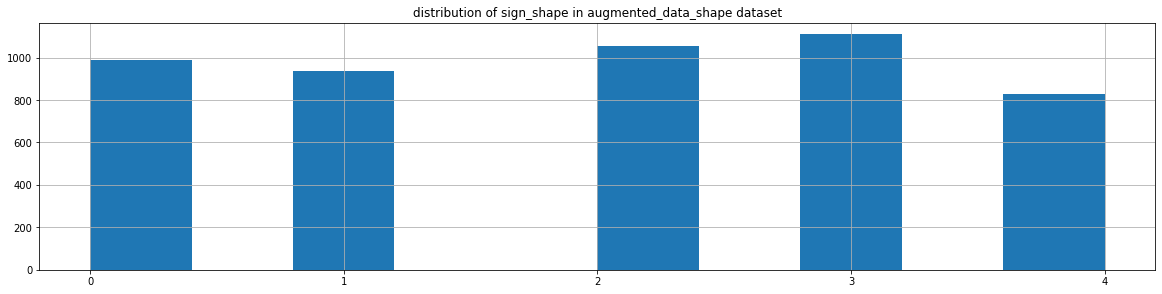

In [26]:
label_encoder(augmented_data_shape)
plot_distribution(augmented_data_shape, "augmented_data_shape")

### 1.6.2 Type Data Augmentation

In [27]:
# generate new data
img_augmentation('./augmented_type/train/square/continue', 1)
img_augmentation('./augmented_type/train/square/crossing', 5)
img_augmentation('./augmented_type/train/triangle/giveaway', 9)
img_augmentation('./augmented_type/train/square/laneend', 2)
img_augmentation('./augmented_type/train/round/limitedtraffic', 4)
img_augmentation('./augmented_type/train/square/parking', 1)
img_augmentation('./augmented_type/train/diamond/rightofway', 1)
img_augmentation('./augmented_type/train/round/speed',1)
img_augmentation('./augmented_type/train/hex/stop', 1)
img_augmentation('./augmented_type/train/round/trafficdirective', 1)

./augmented_type/train/square/continue/*.png
./augmented_type/train/square/crossing/*.png
./augmented_type/train/triangle/giveaway/*.png
./augmented_type/train/square/laneend/*.png
./augmented_type/train/round/limitedtraffic/*.png
./augmented_type/train/square/parking/*.png
./augmented_type/train/diamond/rightofway/*.png
./augmented_type/train/round/speed/*.png
./augmented_type/train/hex/stop/*.png
./augmented_type/train/round/trafficdirective/*.png


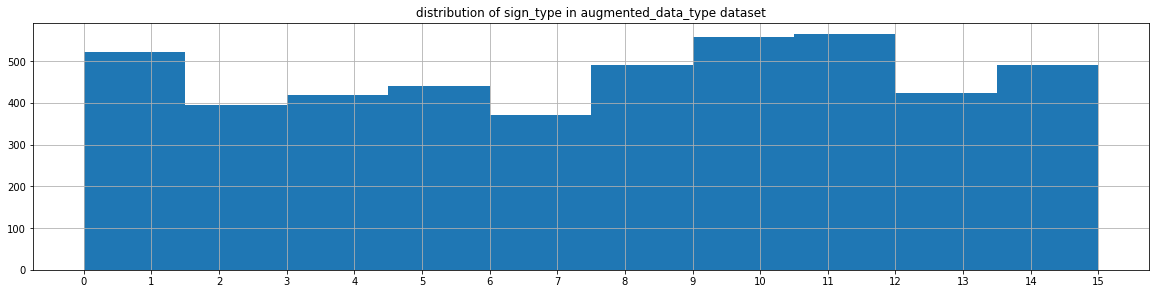

In [28]:
augmented_data_type = file_path_into_dataframe('./augmented_type/train/*/*/*.png')
label_encoder(augmented_data_type)
del augmented_data_type["sign_shape"]
plot_distribution(augmented_data_type, "augmented_data_type")

# **2. Model Development**
* **Goal**: Implementing and comparing the performance of MLP and CNN model. 
* **Setup the experiment**: We will be using 80% of the original dataset as training data and 20% of the data to test (unseen data). From the 80% training data we will split again into 80% training and 20% validation data (data to evaluate the model).  


## **2.1 Generating data**

### **Data Generator Utils**

All the functions that will be repeately used throughout `section 2.1` will be included in this section.

In [29]:
# Checking the shape of train dataset and validation dataset again
train_data.shape, val_data.shape

((2214, 3), (735, 3))

In [30]:
def to_grayscale(image):
    image = tf.image.rgb_to_grayscale(image)
    return image

In [31]:
def generating_data_from_dataframe(dataframe, target, preprocessing_function = None, test = False):
    
    """
        Function to convert the refering target_column_name into string array
        and generate actual data from file path
    """
    dataframe.loc[:,target] = dataframe.loc[:,target].astype('str')
    if preprocessing_function is None:
      generator = ImageDataGenerator(rescale = 1./255, data_format = 'channels_last')
    else: 
      generator = ImageDataGenerator(rescale = 1./255, data_format = 'channels_last', preprocessing_function = to_grayscale)
    batch_size = 32
    if test == False:
      data_gen = generator.flow_from_dataframe(
                                                dataframe = dataframe,
                                                directory = './',
                                                x_col = "image_path",
                                                y_col = target,
                                                target_size = (28, 28),
                                                batch_size = batch_size,
                                                class_mode = 'categorical')
    else:
      data_gen = generator.flow_from_dataframe(
                                                  dataframe = dataframe,
                                                  directory = './',
                                                  x_col = "image_path",
                                                  y_col = target,
                                                  target_size = (28, 28),
                                                  batch_size = batch_size,
                                                  class_mode = 'categorical',
                                                  shuffle = False)
    return data_gen
        

### **2.1.1 Shape Data**

In [32]:
# generate data for train & validation
train_shape = generating_data_from_dataframe(train_data, "sign_shape")
validation_shape = generating_data_from_dataframe(val_data, "sign_shape")


Found 2214 validated image filenames belonging to 5 classes.
Found 735 validated image filenames belonging to 5 classes.


### **2.1.2 Type Data**

In [33]:
# generate data for train & validation
train_type = generating_data_from_dataframe(train_data, "sign_type")
validation_type = generating_data_from_dataframe(val_data, "sign_type")


Found 2214 validated image filenames belonging to 16 classes.
Found 735 validated image filenames belonging to 16 classes.


### **2.1.3 Augmented Shape Data**

In [34]:
# generate data for augmented_shape dataset 
augmented_train_shape = generating_data_from_dataframe(augmented_data_shape, "sign_shape")

Found 4917 validated image filenames belonging to 5 classes.


### **2.1.4 Augmented Type Data**

In [35]:
# generate data for augmented_type dataset
augmented_train_type = generating_data_from_dataframe(augmented_data_type, "sign_type")

Found 4674 validated image filenames belonging to 16 classes.


## **2.2 Model Development**

### **Model Development Utils**

All the functions that will be repeately used throughout `section 2.2` will be included in this section.

In [36]:
input_dimension = (28,28,3)
numbers_of_shape = len(train_data.sign_shape.unique())
numbers_of_sign = len(train_data.sign_type.unique())

In [37]:
early_stopping = tf.keras.callbacks.EarlyStopping(
                      monitor="val_loss",
                      min_delta=0.0001,
                      patience=15,
                      verbose=1,
                      mode="auto",
                      baseline=None,
                      restore_best_weights=True,
                  )

In [38]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [39]:
# calculate class weights to solve the imbalance class problem
class_weights_shape = class_weight.compute_class_weight('balanced',
                                                 classes = train_data.sign_shape.unique(),
                                                 y = train_data.sign_shape.to_numpy())
# convert to dict format
class_weight_dict_shape = dict()
i = 0
for w in class_weights_shape:
    class_weight_dict_shape[i] = w
    i= i+1


In [40]:
# calculate class weights
class_weights_sign = class_weight.compute_class_weight('balanced',
                                                 classes = train_data.sign_type.unique(),
                                                 y = train_data.sign_type.to_numpy())
# convert to dict format
class_weight_dict_sign = dict()
i = 0
for w in class_weights_sign:
    class_weight_dict_sign[i] = w
    i= i+1

### **2.2.1 Multilayer Perceptrons Network**

Our base model for multilayer perceptrons networks consists of 3 layers, inlcuding a flatten layer, a hidden lense layer and a output dense layer.

The aim of this section would be to evaluate the performance of this architecture on the validation set and modify this architecture accordingly to observations so as to improve accuracy, convergent time as well as reducing overfit/underfit.

#### **2.2.1.1 Shape Classification**

###### **2.2.1.1.1. Base Model**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


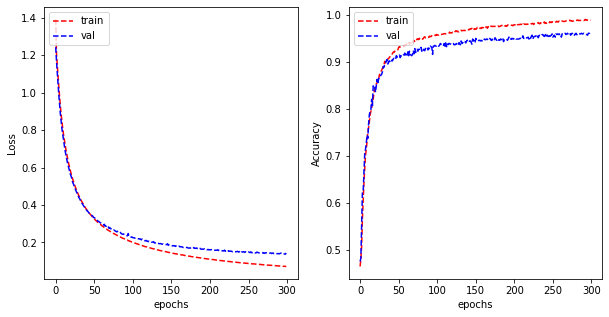

In [41]:
# build model
base_model_mpl_shape = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_dimension),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(numbers_of_shape, activation ='softmax')
])
# comile model
base_model_mpl_shape.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])
# train model
history = base_model_mpl_shape.fit_generator(train_shape, validation_data = validation_shape, epochs=300, verbose=0)
# plot 
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

<u>Observation:</u><br>
* The model does not need 300 epochs to converges. 
* The accuracies of train and validation are around 92% at convergent point.
* Overfitting starts to occur after 100 epochs where performance on train set showed to be better than validation set.


<u>Actions:</u><br>
Although the accuracy is quite good, our aim is to test whether a higher accuracy is achieveable as well as whether the model can converge faster.
We would also need to solve the problem of overfitting.
For this reason, we will tune certain parameters.

In [42]:
base_model_mpl_shape.save("shape_based_MLP_model")     
!cp -R ./shape_based_MLP_model /content/gdrive/'My Drive'/COSC2673_2110/     

INFO:tensorflow:Assets written to: shape_based_MLP_model/assets


###### **2.2.1.1.2 Parameters Tuning Model**

***Class Weight***

Since we have an unbalanced dataset, we will try to include the `class_weight` parameters with the weights being the number of items available in  one class. This is one way of improving the accuracy of the model without the need to change the model architecture.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


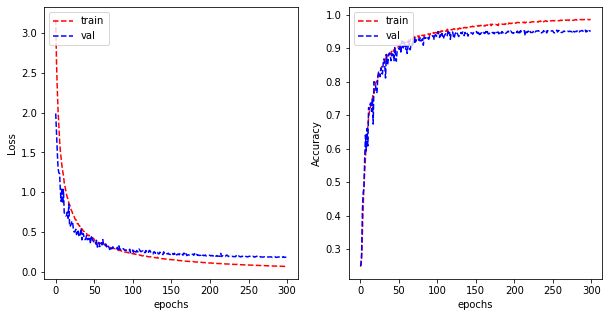

In [43]:
# build model
base_model_mpl_shape_with_classweight = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_dimension),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(numbers_of_shape, activation ='softmax')
])
# comile model
base_model_mpl_shape_with_classweight.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])
# train model
history = base_model_mpl_shape_with_classweight.fit_generator(train_shape, validation_data = validation_shape, class_weight=class_weight_dict_shape,  epochs=300, verbose=0)
# plot 
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')


<u>Observation:</u><br>
* Although `class_weight` parameter is included, the accuracy of the model is not much higher comparing to the baseline one. An explanation for this would be that class imbalance is not the factor that affecting the accuracy of the model. 
* The model converges much faster than the baseline model (Ex: the accuracy of this model after 20 epoches is about 70% while for the baseline model it is only at 50%) 


<u>Actions:</u><br>
* We would want to change the architecture and see whether the accuracy would be improved.
* Firstly we would test whether increase the number of neurons in one hidden layer will improve the accuracy.


***Adding Neurons to Hidden Layer***

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


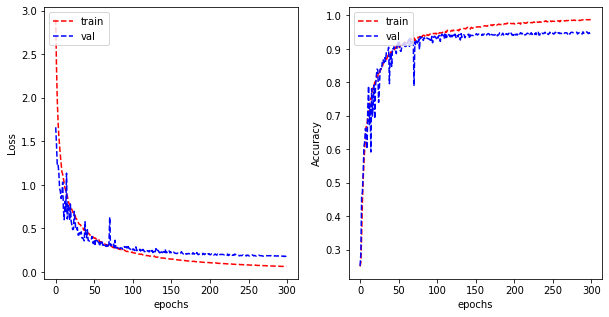

In [44]:
# Increase the number of neurons in the 1st hidden layer
model_mlp2_shape = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_dimension),
    # 1st layer
    tf.keras.layers.Dense(128, activation = "sigmoid"),
    tf.keras.layers.Dense(numbers_of_shape, activation='softmax' )
])

    # loss function
model_mlp2_shape.compile(optimizer=keras.optimizers.SGD(),
                 loss='CategoricalCrossentropy',
                 metrics=['categorical_accuracy'])

# feed data to model
history = model_mlp2_shape.fit_generator(train_shape, validation_data = validation_shape, epochs=300, verbose=0,class_weight=class_weight_dict_shape)
#plot
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')


<u>Observation:</u><br>
* The accuracy is slightly higher (around 1%), as expected, when we increase the number of neurons in the hidden layer.
* The 2 models converge at similar rate, however, overfit problem occurs much earlier comparing to the previous model. 


<u>Actions:</u><br>
* We will test adding another hidden layer and expect the accuracy will further be


***Adding Hidden Layer***

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


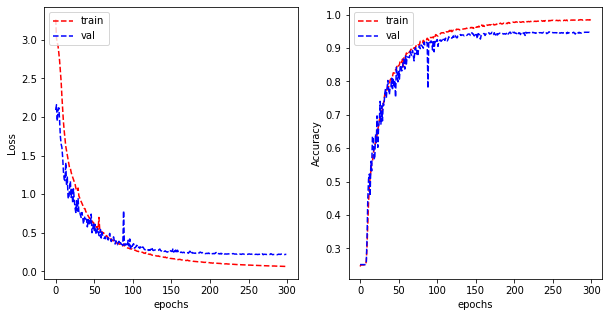

In [45]:
# increase the number of hidden layers 
model_mlp3_shape = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_dimension),
    # 1st layer
    tf.keras.layers.Dense(128, activation = "sigmoid"),
    # 2nd layer
    tf.keras.layers.Dense(128, activation = "sigmoid")  ,
    tf.keras.layers.Dense(numbers_of_shape, activation='softmax' )
])

    # loss function
model_mlp3_shape.compile(optimizer=keras.optimizers.SGD(),
                 loss='CategoricalCrossentropy',
                 metrics=['categorical_accuracy'])

# feed data to model
history = model_mlp3_shape.fit_generator(train_shape, validation_data = validation_shape, epochs=300, verbose=0,class_weight=class_weight_dict_shape)
#plot
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')


<u>Observation:</u><br>
* The model shows to be slightly overfitted (around 2%), however, the accuracy does not increase as much as before. 



<u>Actions:</u><br>
* It seems like using this same activation function `sigmoid` the model has already reached an saturation point where changing the model architecture no longer can improve the accuracy. For this reason we will test if we can improve the convergant rate by changing the activation to `relu`. 


***Relu Activation***

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


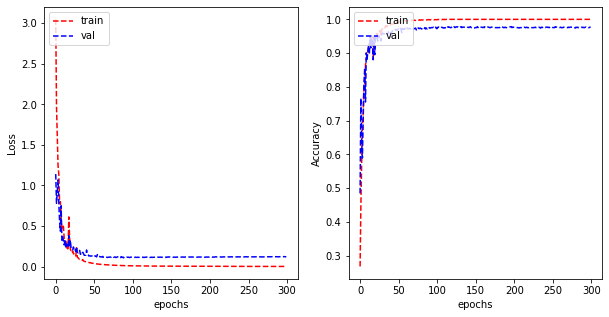

In [46]:
# Add normalization
model_mlp4_shape = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_dimension),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation = "relu")  ,
    tf.keras.layers.Dense(numbers_of_shape, activation='softmax' )
])

    # loss function
model_mlp4_shape.compile(optimizer=keras.optimizers.SGD(),
                 loss='CategoricalCrossentropy',
                 metrics=['categorical_accuracy'])

# feed data to model
history = model_mlp4_shape.fit_generator(train_shape, validation_data = validation_shape, epochs=300, verbose=0 ,class_weight=class_weight_dict_shape)

plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')



<u>Observation:</u><br>
* Convergent rate is much faster and accuracy is still being kept at very high.  
* When changing from `sigmoid` parameter to `relu` the model shows a similar overfit percentage (2% comparing to 1%) when training until convergent. 
* For this reason we will keep on improving the model using `relu` activation function instead of `sigmoid`. 



<u>Actions:</u><br>
* As overfit is oberved, we will apply certain technique trying to solve this problem. 
* Techniques that will be tested including `kernal_regulizer`, `dropout`, and `early_stopping`.  

***Ridge Regularization***

We will test 2 different alpha value which is 0.001 and 0.01 and compare their impacts on the model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


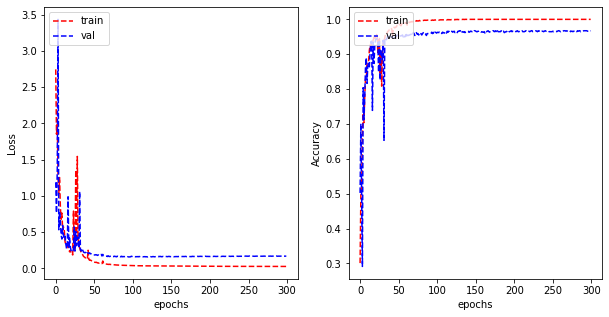

In [47]:
# regularisation
model_mlp5_shape = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_dimension),
    tf.keras.layers.Dense(128, activation = "relu", kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dense(numbers_of_shape, activation='softmax')
])

    # loss function
model_mlp5_shape.compile(optimizer=keras.optimizers.SGD(),
                 loss='CategoricalCrossentropy',
                 metrics=['categorical_accuracy'])

# feed data to model
history = model_mlp5_shape.fit_generator(train_shape, validation_data = validation_shape, epochs=300, verbose=0,class_weight=class_weight_dict_shape)

plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


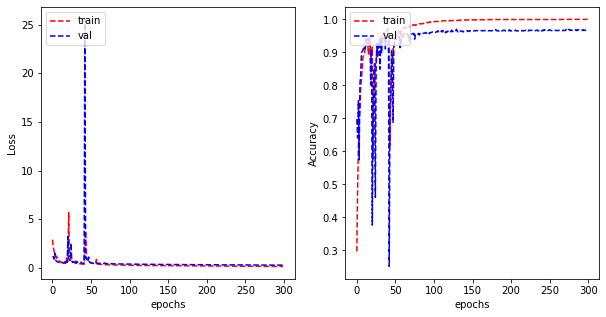

In [48]:
# regularisation
model_mlp6_shape = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_dimension),
    tf.keras.layers.Dense(128, activation = "relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dense(numbers_of_shape, activation='softmax')
])

    # loss function
model_mlp6_shape.compile(optimizer=keras.optimizers.SGD(),
                 loss='CategoricalCrossentropy',
                 metrics=['categorical_accuracy'])

# feed data to model
history = model_mlp6_shape.fit_generator(train_shape, validation_data = validation_shape, epochs=300, verbose=0,class_weight=class_weight_dict_shape)

plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')


<u>Observation:</u><br>
* Model seems to be less overfit when regularization is being used. 
* The model that used an alpha 0.001, however, shows an accuracy drops after 100 epochs. This means that an alpha of 0.001 is too large for this dataset as the higher this alpha coefficient, the higher the shrinkage.  



<u>Actions:</u><br>
* We would first further test out other technique to lower the overfit. The next techniques that will be applied are `dropout`, which will disable certain neurons during training, and `early_stopping`, which will stop training when validation accuracy stop improving.
* These two techniques do not work well together as `dropout` often reduces the accuracy of the model so it is better to have longer training epoch. For this reason, these two techniques will be used separately. 


***Dropout***

The technique has an effect of preventing weights from being overly dependent on each other.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


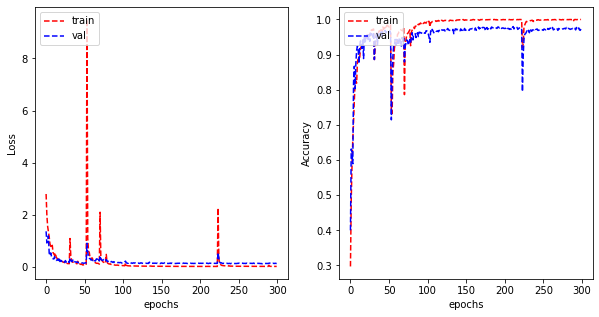

In [49]:
model_mlp7_shape = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_dimension),
    tf.keras.layers.Dense(128, activation = "relu", kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(numbers_of_shape, activation='softmax')
])

    # loss function
model_mlp7_shape.compile(optimizer=keras.optimizers.SGD(),
                 loss='CategoricalCrossentropy',
                 metrics=['categorical_accuracy'])

# feed data to model
history = model_mlp7_shape.fit_generator(train_shape, validation_data = validation_shape, epochs=300, verbose=0,class_weight=class_weight_dict_shape)

plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')



***Early Stopping***



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Restoring model weights from the end of the best epoch: 35.
Epoch 50: early stopping


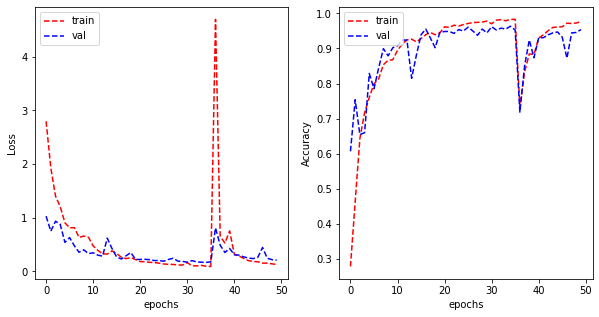

In [50]:
model_mlp8_shape = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_dimension),
    tf.keras.layers.Dense(128, activation = "relu", kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dense(numbers_of_shape, activation='softmax')
])

    # loss function
model_mlp8_shape.compile(optimizer=keras.optimizers.SGD(),
                 loss='CategoricalCrossentropy',
                 metrics=['categorical_accuracy'])

# feed data to model
history = model_mlp8_shape.fit_generator(train_shape, validation_data = validation_shape, epochs=300, verbose=0,class_weight=class_weight_dict_shape, callbacks = [early_stopping])

plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')



<u>Observation:</u><br>
* Both models using `dropout` and `early_stopping` shows similar performance in term of accuracy and convergent. However, `early_stopping` allow the model to stop training only after 122 epoches and for this reason, this model is saved to evaluate on the test set.


In [51]:
model_mlp8_shape.save("shape_fine_tuned_MLP_model")     
!cp -R ./shape_fine_tuned_MLP_model /content/gdrive/'My Drive'/COSC2673_2110/      

INFO:tensorflow:Assets written to: shape_fine_tuned_MLP_model/assets


###### **2.2.1.1.3 Model for Augmented data for Shape (no class weight)**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Restoring model weights from the end of the best epoch: 35.
Epoch 50: early stopping


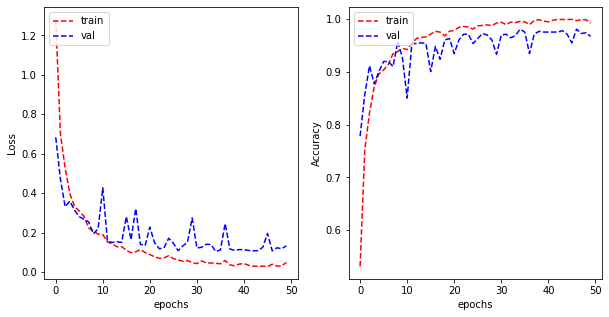

In [52]:
# regularisation
model_mlp_shape_augmented = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_dimension),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(numbers_of_shape, activation='softmax')
])

    # loss function
model_mlp_shape_augmented.compile(optimizer=keras.optimizers.SGD(),
                 loss='CategoricalCrossentropy',
                 metrics=['categorical_accuracy'])

# feed data to model
history = model_mlp_shape_augmented.fit_generator(augmented_train_shape, validation_data = validation_shape, epochs=300, verbose=0,callbacks = [early_stopping])

plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')


<u>Observation:</u><br>
* We use the augmented data to train the model. Comparing to the previous model, the accuracies for train and validation decrease and the convergent is faster. However, it converged faster

In [53]:
model_mlp_shape_augmented.save("shape_model_mlp_augmented")     
!cp -R ./shape_model_mlp_augmented /content/gdrive/'My Drive'/COSC2673_2110/    

INFO:tensorflow:Assets written to: shape_model_mlp_augmented/assets


#### **2.2.1.2 Type Classification**


###### **2.2.1.2.1 Base Model**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


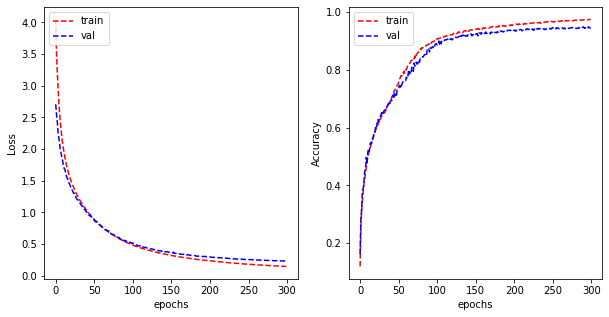

In [54]:
base_model_mlp_type = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_dimension),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(numbers_of_sign)
])

base_model_mlp_type.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

history = base_model_mlp_type.fit_generator(train_type, validation_data=validation_type, epochs=300, verbose=0, class_weight=class_weight_dict_sign)


plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')



<u>Observation:</u><br>
* This base model performs quite well on both training set and validation set, however, we would want to achieve slightly higher accuracy. 
* We would first try to boost the model accuracy a bit further by adding more neurons and another hidden layer. Then, we will implement techniques to solve overfitting. 

In [55]:
base_model_mlp_type.save("sign_base_model_mlp")     
!cp -R ./sign_base_model_mlp /content/gdrive/'My Drive'/COSC2673_2110/    

INFO:tensorflow:Assets written to: sign_base_model_mlp/assets



##### **2.2.1.2.2 Parameters Tuning Model**



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


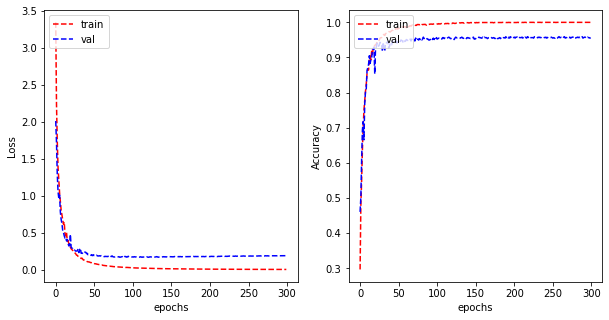

In [56]:
model_mlp1_type = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_dimension),
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dense(numbers_of_sign, activation='softmax')
])

    # loss function
model_mlp1_type.compile(optimizer=keras.optimizers.SGD(),
                 loss='CategoricalCrossentropy',
                 metrics=['categorical_accuracy'])

# feed data to model
history = model_mlp1_type.fit_generator(train_type, validation_data = validation_type, epochs=300, verbose=0,class_weight=class_weight_dict_sign)

plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')



<u>Observation:</u><br>
* We can see that by increasing the number of neurons and add 1 more layers the model now has been able to increase its accuracy by 2%. 
* We still need to try to solve the problem of overfitting so a combination of techniques including `regularization` and `early_stopping` will be used.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


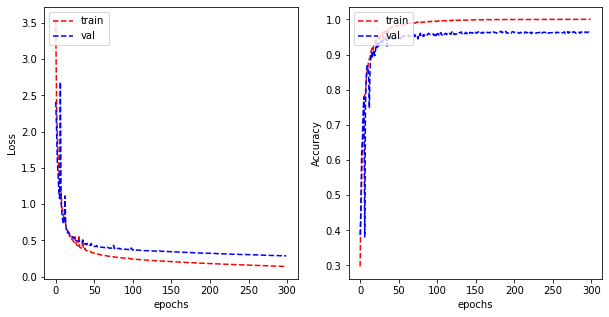

In [57]:
model_mlp2_type = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_dimension),
    tf.keras.layers.Dense(128, activation = "relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dense(numbers_of_sign, activation='softmax')
])

    # loss function
model_mlp2_type.compile(optimizer=keras.optimizers.SGD(),
                 loss='CategoricalCrossentropy',
                 metrics=['categorical_accuracy'])

# feed data to model
history = model_mlp2_type.fit_generator(train_type, validation_data = validation_type, epochs=300, verbose=0,class_weight=class_weight_dict_sign)

plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


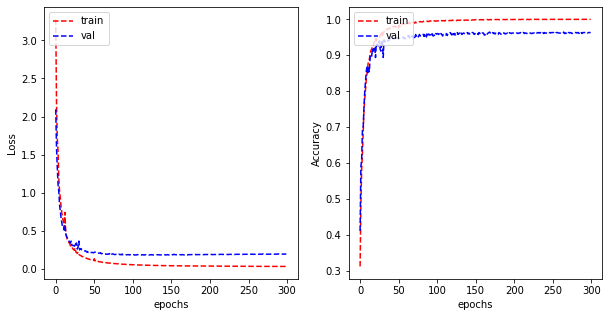

In [58]:
model_mlp3_type = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_dimension),
    tf.keras.layers.Dense(128, activation = "relu", kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dense(numbers_of_sign, activation='softmax')
])

    # loss function
model_mlp3_type.compile(optimizer=keras.optimizers.SGD(),
                 loss='CategoricalCrossentropy',
                 metrics=['categorical_accuracy'])

# feed data to model
history = model_mlp3_type.fit_generator(train_type, validation_data = validation_type, epochs=300, verbose=0,class_weight=class_weight_dict_sign)

plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')



<u>Observation:</u><br>
* In model 2, a regularization of 0.0001 is used, while in model 3, a regularization of 0.001 is used. 
* These 2 models show similar level of overfit and accuracy is also not much different. WE will save model 3 to test with the test set.

In [59]:
model_mlp3_type.save("sign_fine_tuned_MLP_model")     
!cp -R ./sign_fine_tuned_MLP_model /content/gdrive/'My Drive'/COSC2673_2110/    

INFO:tensorflow:Assets written to: sign_fine_tuned_MLP_model/assets



##### **2.2.1.2.3 Model for augmented data for type (no class weight)**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


Restoring model weights from the end of the best epoch: 124.
Epoch 139: early stopping


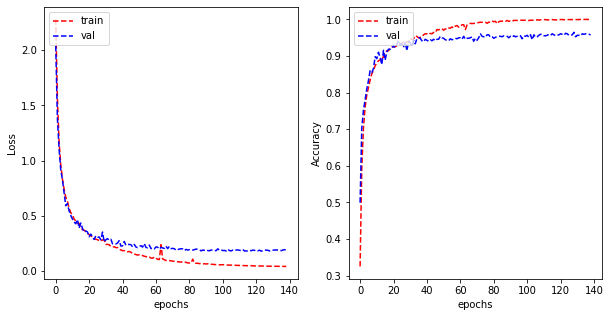

In [60]:
# regularisation
model_mpl_augmented_type= tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_dimension),
    tf.keras.layers.Dense(128, activation = "relu", kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dense(numbers_of_sign, activation='softmax' )
])

    # loss function
model_mpl_augmented_type.compile(optimizer=keras.optimizers.SGD(),
                 loss='CategoricalCrossentropy',
                 metrics=['categorical_accuracy'])

# feed data to model
history = model_mpl_augmented_type.fit_generator(augmented_train_type, validation_data = validation_type, epochs=300, verbose=0,callbacks = [early_stopping]   )

plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')



<u>Observation:</u><br>
* The augmented data is used to train the model.
* The accuracies of train and validation decreased but the convergent is faster comparing to the previous model. However, model is overfitted with an increasing of the gap between train and validation data.

In [61]:
model_mpl_augmented_type.save("sign_model_mpl_augmented")     
!cp -R ./sign_model_mpl_augmented /content/gdrive/'My Drive'/COSC2673_2110/    

INFO:tensorflow:Assets written to: sign_model_mpl_augmented/assets


### **2.2.2 Convolution Neural Network**

In this section, we will implement two popular CNN architectural namely VGG and LeNet as our baseline model. Depending on the result, we will configure the architecture so as to be able to figure out the best solution for this image classification problem.

#### **A. VGG CNN Baseline Model**


The VGG architecture that was used as the baseline model for this project is the modified architecture that was provided in the lecture (**link**). 

This modified architecture was chosen over the original VGG architecture as the original one contains many VGG - block (convolution + activation + pooling) and it is more suitable for larger image, however, our image is only of 28 * 28, which makes the modified version preferable. 

In [62]:
def create_VGG_Model(output):
  VGG_model = tf.keras.Sequential([
      # Block 1
      tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', input_shape=input_dimension),
      tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.MaxPooling2D((2, 2)),
      
      # Block 2
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.MaxPooling2D((2, 2)),
      
      # Block 3
      tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.MaxPooling2D((2, 2)),
      
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(output, activation = "softmax"),
      ])
  VGG_model.summary()
  return VGG_model

#### **B. LeNet CNN Baseline Model**

In [63]:
def create_LeNet_model(output):
  reg_lambda = 0.001

  LeNet_model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=input_dimension),
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
      
      
      tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
      tf.keras.layers.Activation('relu'),
      tf.keras.layers.MaxPool2D(pool_size=(2,2)),
      
      tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Conv2D(64, (3, 3)),
      tf.keras.layers.Activation('relu'),
      tf.keras.layers.MaxPool2D(pool_size=(2,2)),
      
      tf.keras.layers.Flatten(),
      
      tf.keras.layers.Dense(64),
      tf.keras.layers.Activation('relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(output, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
  ])
  return LeNet_model



#### **2.2.2.1 Shape Classification**

##### 2.2.2.1.1 VGG Base

In [64]:
VGG_model_shape = create_VGG_Model(numbers_of_shape)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 28)        784       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 28)        7084      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 28)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        16192     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


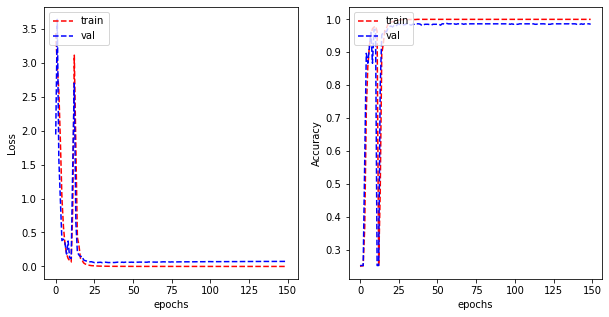

In [65]:
VGG_model_shape.compile(
              # Use sgd over adam as our dataset is not very large so we care more about generalized
              # adam would be better in case we need the data to be able to converge faster
              optimizer = 'sgd',
              # Use categorical_crossentropy instead of sparse as we use one hot label encoder
              loss = "categorical_crossentropy",     
              metrics = ['categorical_accuracy'])
  
# Early stopping is included to prevent long training time
# Training will be interupt if there is no further improvement in validation set
# restore_best_weights arguement is used to return the model to the best model
history = VGG_model_shape.fit_generator(train_shape, validation_data = validation_shape, epochs=150, class_weight=class_weight_dict_shape, verbose=0)
  
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name = 'Accuracy')

**Observations:**
- Although the model has high accuracy and early-stopping has been implemented to prevent long training time as well as overfitting, it seems like the model is still overfit. 
- One of the reason for this is that, in the base architecture of VGG that was used, regularization and dropout has not been implemented. In the next sections, these 2 techniques to solve overfitting will be implemented. 

In [66]:
VGG_model_shape.save("shape_VGG_base_model")     
!cp -R ./shape_VGG_base_model /content/gdrive/'My Drive'/COSC2673_2110/        

INFO:tensorflow:Assets written to: shape_VGG_base_model/assets


##### 2.2.2.1.2 LeNet Base

In [67]:
LeNet_model_shape = create_LeNet_model(numbers_of_shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


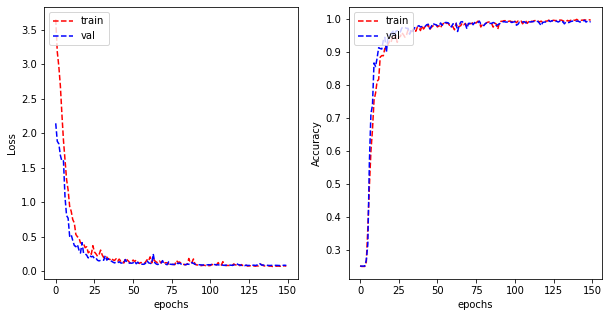

In [68]:
LeNet_model_shape.compile(
              # Use sgd over adam as our dataset is not very large so we care more about generalized
              # adam would be better in case we need the data to be able to converge faster
              optimizer = 'sgd',
              # Use categorical_crossentropy instead of sparse as we use one hot label encoder
              loss = "categorical_crossentropy",     
              metrics = ['categorical_accuracy'])
  
# Early stopping is included to prevent long training time
# Training will be interupt if there is no further improvement in validation set
# restore_best_weights arguement is used to return the model to the best model
history = LeNet_model_shape.fit_generator(train_shape, validation_data = validation_shape, epochs=150, class_weight=class_weight_dict_shape, verbose=0)
  
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name = 'Accuracy')

In [69]:
LeNet_model_shape.save("shape_LeNet_base_model")
!cp -R ./shape_LeNet_base_model /content/gdrive/'My Drive'/COSC2673_2110/

INFO:tensorflow:Assets written to: shape_LeNet_base_model/assets


##### **2.2.2.1.3 L2 Regularization (tuning regularization lambda)**

In [70]:
def parameters(reg_lambda, output):
    VGG_model_with_regularization = tf.keras.Sequential([
    # Block 1
    tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer = tf.keras.regularizers.L2(reg_lambda), input_shape=input_dimension),
    tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same',
                           kernel_regularizer= tf.keras.regularizers.L2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                           kernel_regularizer=tf.keras.regularizers.L2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                                  kernel_regularizer=tf.keras.regularizers.L2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                           kernel_regularizer=tf.keras.regularizers.L2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.L2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(reg_lambda)),
    tf.keras.layers.Dense(output, activation = "softmax"),
    ])

    VGG_model_with_regularization.compile(
              # Use sgd over adam as our dataset is not very large so we care more about generalized
              # adam would be better in case we need the data to be able to converge faster
              optimizer = 'sgd',
              # Use categorical_crossentropy instead of sparse as we use one hot label encoder
              loss = "categorical_crossentropy",     
              metrics = ['categorical_accuracy'])
  
    return VGG_model_with_regularization
  
  
def build_model_VGG_l2_regular_shape(hp):
    reg_lambda = hp.Choice('reg_lambda', [0.001, 0.01, 0.1])
    model = parameters(reg_lambda, numbers_of_shape)
    return model

build_model_VGG_l2_regular_shape(kt.HyperParameters())

In [71]:
tuner_reg_l2_shape = kt.RandomSearch(
    build_model_VGG_l2_regular_shape,
    objective='val_loss',
    max_trials=3,
    overwrite = True)
tuner_reg_l2_shape.search_space_summary()

Search space summary
Default search space size: 1
reg_lambda (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.01, 0.1], 'ordered': True}


In [72]:
tuner_reg_l2_shape.search(train_shape, epochs= 150, verbose = 0, validation_data=validation_shape, class_weight=class_weight_dict_shape)

INFO:tensorflow:Oracle triggered exit


In [73]:
tuner_reg_l2_shape.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
reg_lambda: 0.01
Score: 0.3974679112434387
Trial summary
Hyperparameters:
reg_lambda: 0.001
Score: 0.4403785765171051
Trial summary
Hyperparameters:
reg_lambda: 0.1
Score: 1.0779920816421509


In [74]:
# get best model and best hyper parameter
best_model = tuner_reg_l2_shape.get_best_models()[0]
best_hp = tuner_reg_l2_shape.get_best_hyperparameters()[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 28)        784       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 28)        7084      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 28)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        16192     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


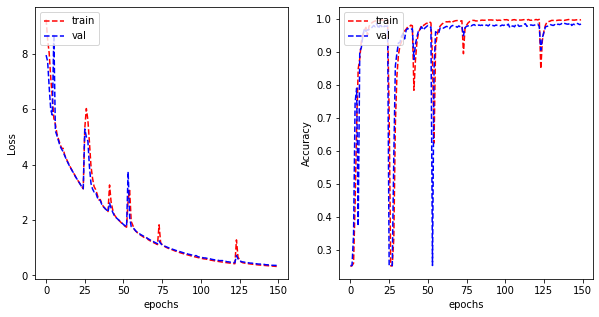

In [75]:
model_VGG_best_regularization_l2_shape = tuner_reg_l2_shape.hypermodel.build(best_hp)
history = model_VGG_best_regularization_l2_shape.fit_generator(train_shape, validation_data = validation_shape, epochs=150, verbose=0, class_weight=class_weight_dict_shape)
  
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name = 'Accuracy')

In [76]:
model_VGG_best_regularization_l2_shape.save("shape_VGG_tuneL2_model")
!cp -R ./shape_VGG_tuneL2_model /content/gdrive/'My Drive'/COSC2673_2110/

INFO:tensorflow:Assets written to: shape_VGG_tuneL2_model/assets


##### **2.2.2.1.4 Dropout regularization (tuning dropout rate)**

In [77]:
reg_lambda = 0.001
dropout_rate = 0.5

VGG_model_with_regularization_with_dropout_05 = tf.keras.Sequential([
  # Block 1
  tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                          kernel_regularizer = tf.keras.regularizers.l2(reg_lambda), input_shape=input_dimension),
  tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same',
                          kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  
  # Block 2
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                          kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                                kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  
  # Block 3
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                          kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                          kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.Dropout(rate = dropout_rate),
  tf.keras.layers.Dense(numbers_of_shape, activation = "softmax"),
  ])

VGG_model_with_regularization_with_dropout_05.compile(
          # Use sgd over adam as our dataset is not very large so we care more about generalized
          # adam would be better in case we need the data to be able to converge faster
          optimizer = 'sgd',
          # Use categorical_crossentropy instead of sparse as we use one hot label encoder
          loss = "categorical_crossentropy",     
          metrics = ['categorical_accuracy'])
  
  



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


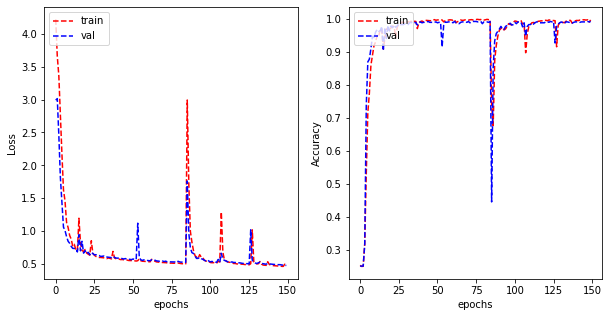

In [78]:
history = VGG_model_with_regularization_with_dropout_05.fit_generator(train_shape, validation_data = validation_shape, epochs=150, verbose=0, class_weight=class_weight_dict_shape)
  
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name = 'Accuracy')

In [79]:
VGG_model_with_regularization_with_dropout_05.save("shape_VGG_tuneL2_DropOut_model_05")
!cp -R ./shape_VGG_tuneL2_DropOut_model_05 /content/gdrive/'My Drive'/COSC2673_2110/

INFO:tensorflow:Assets written to: shape_VGG_tuneL2_DropOut_model_05/assets


In [80]:
reg_lambda = 0.001
dropout_rate = 0.2

VGG_model_with_regularization_with_dropout_02 = tf.keras.Sequential([
  # Block 1
  tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                          kernel_regularizer = tf.keras.regularizers.l2(reg_lambda), input_shape=input_dimension),
  tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same',
                          kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  
  # Block 2
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                          kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                                kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  
  # Block 3
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                          kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                          kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.Dropout(rate = dropout_rate),
  tf.keras.layers.Dense(numbers_of_shape, activation = "softmax"),
  ])

VGG_model_with_regularization_with_dropout_02.compile(
          # Use sgd over adam as our dataset is not very large so we care more about generalized
          # adam would be better in case we need the data to be able to converge faster
          optimizer = 'sgd',
          # Use categorical_crossentropy instead of sparse as we use one hot label encoder
          loss = "categorical_crossentropy",     
          metrics = ['categorical_accuracy'])
  
  



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


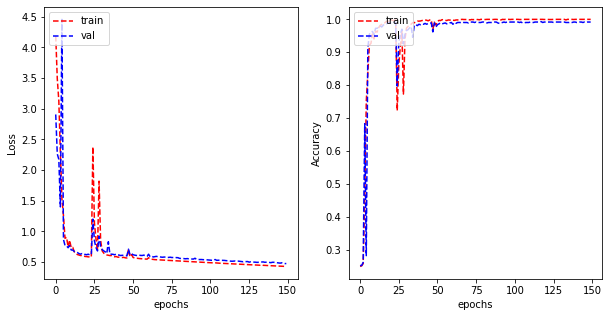

In [81]:
history = VGG_model_with_regularization_with_dropout_02.fit_generator(train_shape, validation_data = validation_shape, epochs=150, verbose=0, class_weight=class_weight_dict_shape)
  
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name = 'Accuracy')

In [82]:
VGG_model_with_regularization_with_dropout_02.save("shape_VGG_tuneL2_DropOut_model_02")
!cp -R ./shape_VGG_tuneL2_DropOut_model_02 /content/gdrive/'My Drive'/COSC2673_2110/

INFO:tensorflow:Assets written to: shape_VGG_tuneL2_DropOut_model_02/assets




#### **2.2.2.2 Type Classification**

##### 2.2.2.2.1 VGG Base

In [83]:
VGG_model_sign = create_VGG_Model(numbers_of_sign)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 28, 28, 28)        784       
                                                                 
 conv2d_25 (Conv2D)          (None, 28, 28, 28)        7084      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 14, 14, 28)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 14, 14, 64)        16192     
                                                                 
 conv2d_27 (Conv2D)          (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


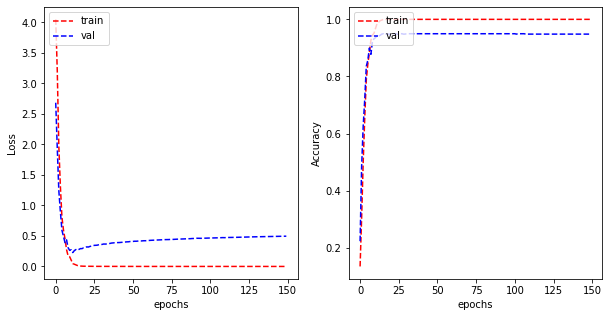

In [84]:
VGG_model_sign.compile(
              # Use sgd over adam as our dataset is not very large so we care more about generalized
              # adam would be better in case we need the data to be able to converge faster
              optimizer = 'sgd',
              # Use categorical_crossentropy instead of sparse as we use one hot label encoder
              loss = "categorical_crossentropy",     
              metrics = ['categorical_accuracy'])
  
# Early stopping is included to prevent long training time
# Training will be interupt if there is no further improvement in validation set
# restore_best_weights arguement is used to return the model to the best model
history = VGG_model_sign.fit_generator(train_type, validation_data = validation_type, epochs=150, class_weight=class_weight_dict_sign, verbose=0)
  
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name = 'Accuracy')

In [85]:
VGG_model_sign.save("sign_VGG_base_model")
!cp -R ./sign_VGG_base_model /content/gdrive/'My Drive'/COSC2673_2110/

INFO:tensorflow:Assets written to: sign_VGG_base_model/assets


#####2.2.2.2.2 LeNet Base

In [86]:
LeNet_model_sign = create_LeNet_model(numbers_of_sign)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


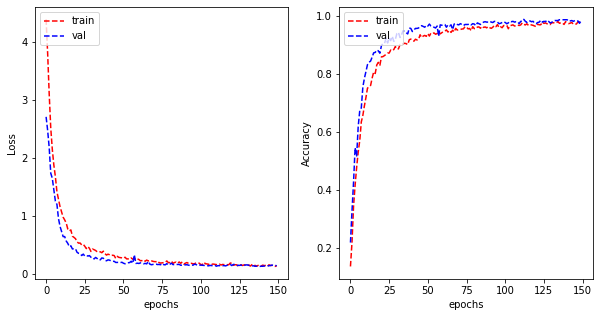

In [87]:
LeNet_model_sign.compile(
              # Use sgd over adam as our dataset is not very large so we care more about generalized
              # adam would be better in case we need the data to be able to converge faster
              optimizer = 'sgd',
              # Use categorical_crossentropy instead of sparse as we use one hot label encoder
              loss = "categorical_crossentropy",     
              metrics = ['categorical_accuracy'])
  
# Early stopping is included to prevent long training time
# Training will be interupt if there is no further improvement in validation set
# restore_best_weights arguement is used to return the model to the best model
history = LeNet_model_sign.fit_generator(train_type, validation_data = validation_type, epochs=150, class_weight=class_weight_dict_sign, verbose=0)
  
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name = 'Accuracy')

In [88]:
LeNet_model_sign.save("sign_LeNet_base_model")
!cp -R ./sign_LeNet_base_model /content/gdrive/'My Drive'/COSC2673_2110/

INFO:tensorflow:Assets written to: sign_LeNet_base_model/assets


##### **2.2.2.2.3 L2 Regularization (tuning regularization lambda)**

In [127]:

def parameters_sign(reg_lambda, output):
    VGG_model_with_regularization = tf.keras.Sequential([
    # Block 1
    tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer = tf.keras.regularizers.L2(reg_lambda), input_shape=input_dimension),
    tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same',
                           kernel_regularizer= tf.keras.regularizers.L2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                           kernel_regularizer=tf.keras.regularizers.L2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                                  kernel_regularizer=tf.keras.regularizers.L2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                           kernel_regularizer=tf.keras.regularizers.L2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.L2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(reg_lambda)),
    tf.keras.layers.Dense(output, activation = "softmax"),
    ])

    VGG_model_with_regularization.compile(
              # Use sgd over adam as our dataset is not very large so we care more about generalized
              # adam would be better in case we need the data to be able to converge faster
              optimizer = 'sgd',
              # Use categorical_crossentropy instead of sparse as we use one hot label encoder
              loss = "categorical_crossentropy",     
              metrics = ['categorical_accuracy'])
  
    return VGG_model_with_regularization
    
def build_model_VGG_l2_reg_sign(hp):
    reg_lambda = hp.Choice('reg_lambda', [0.001, 0.01, 0.1])
    model = parameters_sign(reg_lambda, numbers_of_sign)
    return model

build_model_VGG_l2_reg_sign(kt.HyperParameters())

In [128]:
tuner_reg_l2_sign = kt.RandomSearch(
    build_model_VGG_l2_reg_sign,
    objective='val_loss',
    max_trials=3,
    overwrite = True)
tuner_reg_l2_sign.search_space_summary()

Search space summary
Default search space size: 1
reg_lambda (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.01, 0.1], 'ordered': True}


In [129]:
tuner_reg_l2_sign.search(train_type, epochs=150, verbose = 0, validation_data=validation_type, class_weight=class_weight_dict_sign)

INFO:tensorflow:Oracle triggered exit


In [130]:
tuner_reg_l2_sign.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
reg_lambda: 0.01
Score: 0.470244824886322
Trial summary
Hyperparameters:
reg_lambda: 0.001
Score: 0.6914095878601074
Trial summary
Hyperparameters:
reg_lambda: 0.1
Score: 1.363676905632019


In [131]:
# get best model and best hyper parameter
best_model = tuner_reg_l2_sign.get_best_models()[0]
best_hp = tuner_reg_l2_sign.get_best_hyperparameters()[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 28)        784       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 28)        7084      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 28)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        16192     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


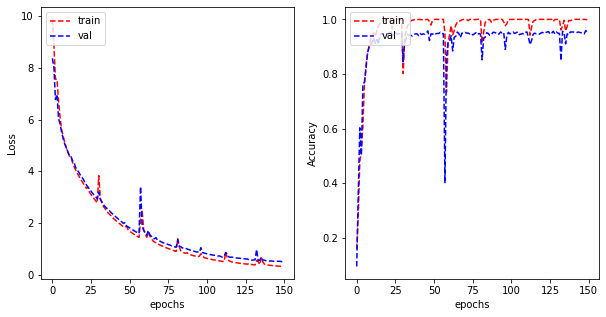

In [132]:
model_VGG_best_regularization_sign = tuner_reg_l2_sign.hypermodel.build(best_hp)
history = model_VGG_best_regularization_sign.fit_generator(train_type, validation_data = validation_type, epochs=150, verbose=0, class_weight=class_weight_dict_sign)
  
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name = 'Accuracy')

In [133]:
model_VGG_best_regularization_sign.save("sign_VGG_tuneL2_model")
!cp -R ./sign_VGG_tuneL2_model /content/gdrive/'My Drive'/COSC2673_2110/

INFO:tensorflow:Assets written to: sign_VGG_tuneL2_model/assets


##### **2.2.2.2.4 Dropout Regularization (tuning dropout rate)**

In [134]:
reg_lambda = 0.001
dropout_rate = 0.5

VGG_model_with_regularization_with_dropout_05 = tf.keras.Sequential([
  # Block 1
  tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                          kernel_regularizer = tf.keras.regularizers.l2(reg_lambda), input_shape=input_dimension),
  tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same',
                          kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  
  # Block 2
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                          kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                                kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  
  # Block 3
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                          kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                          kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.Dropout(rate = dropout_rate),
  tf.keras.layers.Dense(numbers_of_sign, activation = "softmax"),
  ])

VGG_model_with_regularization_with_dropout_05.compile(
          # Use sgd over adam as our dataset is not very large so we care more about generalized
          # adam would be better in case we need the data to be able to converge faster
          optimizer = 'sgd',
          # Use categorical_crossentropy instead of sparse as we use one hot label encoder
          loss = "categorical_crossentropy",     
          metrics = ['categorical_accuracy'])
  
  



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


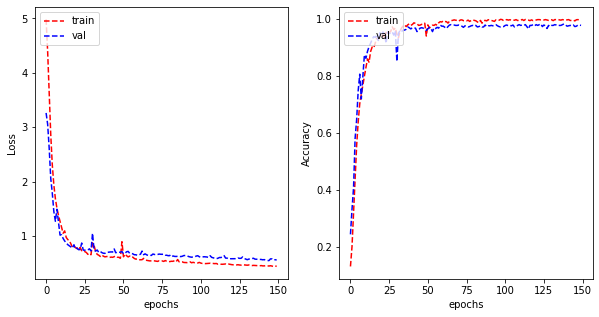

In [135]:
history = VGG_model_with_regularization_with_dropout_05.fit_generator(train_type, validation_data = validation_type, epochs=150, verbose=0, class_weight=class_weight_dict_sign)
  
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name = 'Accuracy')

In [136]:
VGG_model_with_regularization_with_dropout_05.save("sign_VGG_tuneL2_Dropout_model_05")
!cp -R ./sign_VGG_tuneL2_Dropout_model_05 /content/gdrive/'My Drive'/COSC2673_2110/

INFO:tensorflow:Assets written to: sign_VGG_tuneL2_Dropout_model_05/assets


In [137]:
reg_lambda = 0.001
dropout_rate = 0.2

VGG_model_with_regularization_with_dropout_02 = tf.keras.Sequential([
  # Block 1
  tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                          kernel_regularizer = tf.keras.regularizers.l2(reg_lambda), input_shape=input_dimension),
  tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same',
                          kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  
  # Block 2
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                          kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                                kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  
  # Block 3
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                          kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                          kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.Dropout(rate = dropout_rate),
  tf.keras.layers.Dense(numbers_of_sign, activation = "softmax"),
  ])

VGG_model_with_regularization_with_dropout_02.compile(
          # Use sgd over adam as our dataset is not very large so we care more about generalized
          # adam would be better in case we need the data to be able to converge faster
          optimizer = 'sgd',
          # Use categorical_crossentropy instead of sparse as we use one hot label encoder
          loss = "categorical_crossentropy",     
          metrics = ['categorical_accuracy'])
  
  



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


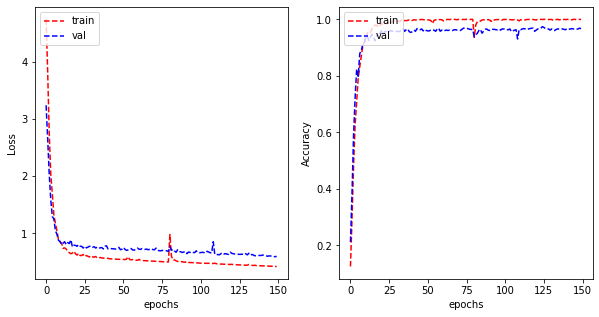

In [138]:
history = VGG_model_with_regularization_with_dropout_02.fit_generator(train_type, validation_data = validation_type, epochs=150, verbose=0, class_weight=class_weight_dict_sign)
  
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name = 'Accuracy')

In [139]:
VGG_model_with_regularization_with_dropout_02.save("sign_VGG_tuneL2_Dropout_model_02")
!cp -R ./sign_VGG_tuneL2_Dropout_model_02 /content/gdrive/'My Drive'/COSC2673_2110/

INFO:tensorflow:Assets written to: sign_VGG_tuneL2_Dropout_model_02/assets


## **2.3. Test Set Result**

In [140]:
# Loading shape model
shape_MLP_base = keras.models.load_model('/content/gdrive/MyDrive/COSC2673_2110/shape_based_MLP_model')
shape_MLP_tuned = keras.models.load_model('/content/gdrive/MyDrive/COSC2673_2110/shape_fine_tuned_MLP_model')
shape_MLP_tuned_augmented = keras.models.load_model('/content/gdrive/MyDrive/COSC2673_2110/shape_model_mlp_augmented')
shape_LeNet_base = keras.models.load_model('/content/gdrive/MyDrive/COSC2673_2110/shape_LeNet_base_model')
shape_VGG_base = keras.models.load_model('/content/gdrive/MyDrive/COSC2673_2110/shape_VGG_base_model')
shape_VGG_tuneL2_DropOut02 = keras.models.load_model('/content/gdrive/MyDrive/COSC2673_2110/shape_VGG_tuneL2_DropOut_model_02')
shape_VGG_tuneL2_DropOut05 = keras.models.load_model('/content/gdrive/MyDrive/COSC2673_2110/shape_VGG_tuneL2_DropOut_model_05')

# Loading sign model
sign_MLP_base = keras.models.load_model('/content/gdrive/MyDrive/COSC2673_2110/sign_base_model_mlp')
sign_MLP_tuned = keras.models.load_model('/content/gdrive/MyDrive/COSC2673_2110/sign_fine_tuned_MLP_model')
sign_MLP_tuned_augmented = keras.models.load_model('/content/gdrive/MyDrive/COSC2673_2110/sign_model_mpl_augmented')
sign_LeNet_base = keras.models.load_model('/content/gdrive/MyDrive/COSC2673_2110/sign_LeNet_base_model')
sign_VGG_base = keras.models.load_model('/content/gdrive/MyDrive/COSC2673_2110/sign_VGG_base_model')
sign_VGG_tuneL2_DropOut02 = keras.models.load_model('/content/gdrive/MyDrive/COSC2673_2110/sign_VGG_tuneL2_Dropout_model_02')
sign_VGG_tuneL2_DropOut05 = keras.models.load_model('/content/gdrive/MyDrive/COSC2673_2110/sign_VGG_tuneL2_Dropout_model_05')

In [141]:
def print_test_evaluation(model, y_true, target_names):
    prediction = model.predict(y_true, workers = 1)
    y_pred = np.argmax(prediction, axis=1)
    cm = confusion_matrix(y_true.classes, y_pred)
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(cm, annot=True,  fmt=".0f", ax = ax, xticklabels=target_names, yticklabels= target_names)
    ax.set(xlabel='Predicted label', ylabel='True label')
    plt.show()
    print("\n" + classification_report(y_true.classes, y_pred, target_names=target_names))



In [142]:
target_names_shape = ["diamond", "hex", "round", "square", "triangle"]
target_names_sign = ["rightofway", "stop", "bicycle", "limitedtraffic", "noentry", "noparking", "roundabout", "speed", "trafficdirective", "traveldirection", "continue", "crossing", "laneend", "parking", "giveway", "warning"]

### **2.3.1. Test Set 1**

In [143]:
test_set_1_shape = generating_data_from_dataframe(test_data, "sign_shape", test = True)
test_set_1_sign = generating_data_from_dataframe(test_data, "sign_type", test = True)


Found 750 validated image filenames belonging to 5 classes.
Found 750 validated image filenames belonging to 16 classes.


#### 2.3.1.1 Shape Classification

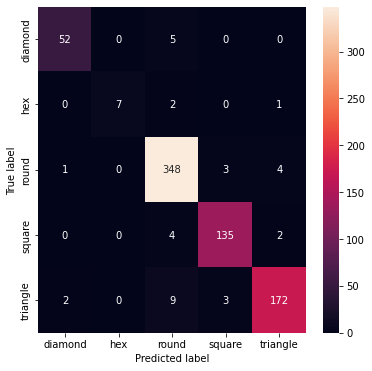


              precision    recall  f1-score   support

     diamond       0.95      0.91      0.93        57
         hex       1.00      0.70      0.82        10
       round       0.95      0.98      0.96       356
      square       0.96      0.96      0.96       141
    triangle       0.96      0.92      0.94       186

    accuracy                           0.95       750
   macro avg       0.96      0.89      0.92       750
weighted avg       0.95      0.95      0.95       750



In [144]:
print_test_evaluation(shape_MLP_base, test_set_1_shape, target_names_shape)

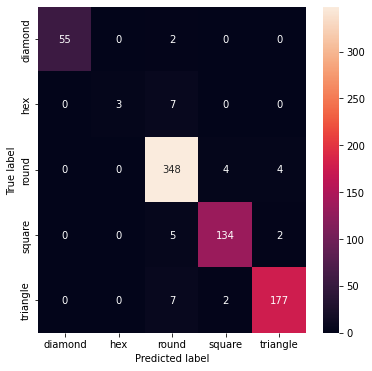


              precision    recall  f1-score   support

     diamond       1.00      0.96      0.98        57
         hex       1.00      0.30      0.46        10
       round       0.94      0.98      0.96       356
      square       0.96      0.95      0.95       141
    triangle       0.97      0.95      0.96       186

    accuracy                           0.96       750
   macro avg       0.97      0.83      0.86       750
weighted avg       0.96      0.96      0.95       750



In [145]:
print_test_evaluation(shape_MLP_tuned, test_set_1_shape, target_names_shape)

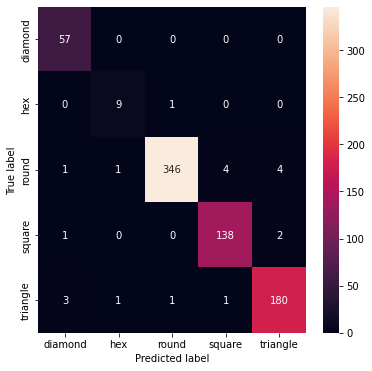


              precision    recall  f1-score   support

     diamond       0.92      1.00      0.96        57
         hex       0.82      0.90      0.86        10
       round       0.99      0.97      0.98       356
      square       0.97      0.98      0.97       141
    triangle       0.97      0.97      0.97       186

    accuracy                           0.97       750
   macro avg       0.93      0.96      0.95       750
weighted avg       0.97      0.97      0.97       750



In [146]:
print_test_evaluation(shape_MLP_tuned_augmented, test_set_1_shape, target_names_shape)

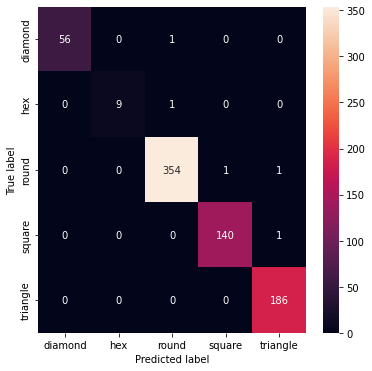


              precision    recall  f1-score   support

     diamond       1.00      0.98      0.99        57
         hex       1.00      0.90      0.95        10
       round       0.99      0.99      0.99       356
      square       0.99      0.99      0.99       141
    triangle       0.99      1.00      0.99       186

    accuracy                           0.99       750
   macro avg       1.00      0.97      0.98       750
weighted avg       0.99      0.99      0.99       750



In [147]:
print_test_evaluation(shape_LeNet_base, test_set_1_shape, target_names_shape)

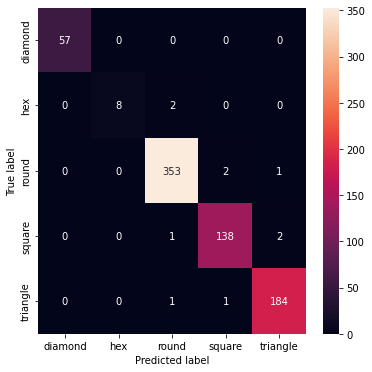


              precision    recall  f1-score   support

     diamond       1.00      1.00      1.00        57
         hex       1.00      0.80      0.89        10
       round       0.99      0.99      0.99       356
      square       0.98      0.98      0.98       141
    triangle       0.98      0.99      0.99       186

    accuracy                           0.99       750
   macro avg       0.99      0.95      0.97       750
weighted avg       0.99      0.99      0.99       750



In [148]:
print_test_evaluation(shape_VGG_base, test_set_1_shape, target_names_shape)

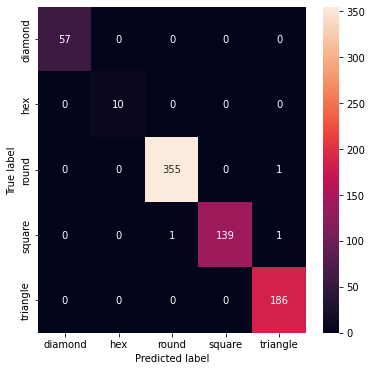


              precision    recall  f1-score   support

     diamond       1.00      1.00      1.00        57
         hex       1.00      1.00      1.00        10
       round       1.00      1.00      1.00       356
      square       1.00      0.99      0.99       141
    triangle       0.99      1.00      0.99       186

    accuracy                           1.00       750
   macro avg       1.00      1.00      1.00       750
weighted avg       1.00      1.00      1.00       750



In [149]:
print_test_evaluation(shape_VGG_tuneL2_DropOut02, test_set_1_shape, target_names_shape)


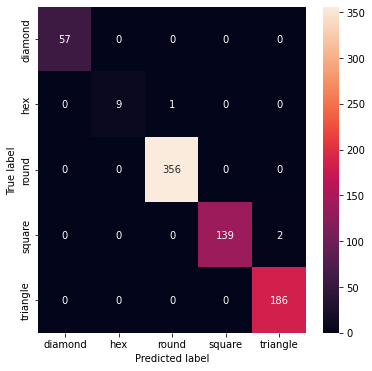


              precision    recall  f1-score   support

     diamond       1.00      1.00      1.00        57
         hex       1.00      0.90      0.95        10
       round       1.00      1.00      1.00       356
      square       1.00      0.99      0.99       141
    triangle       0.99      1.00      0.99       186

    accuracy                           1.00       750
   macro avg       1.00      0.98      0.99       750
weighted avg       1.00      1.00      1.00       750



In [150]:
print_test_evaluation(shape_VGG_tuneL2_DropOut05, test_set_1_shape, target_names_shape)

#### 2.3.1.2 Sign Classification

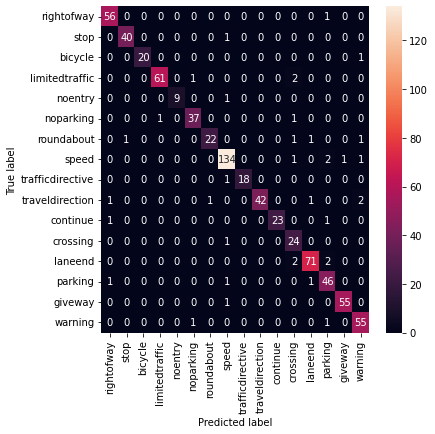


                  precision    recall  f1-score   support

      rightofway       0.95      0.98      0.97        57
            stop       0.98      0.98      0.98        41
         bicycle       1.00      0.95      0.98        21
  limitedtraffic       0.98      0.95      0.97        64
         noentry       1.00      0.90      0.95        10
       noparking       0.95      0.95      0.95        39
      roundabout       0.96      0.85      0.90        26
           speed       0.96      0.96      0.96       139
trafficdirective       1.00      0.95      0.97        19
 traveldirection       1.00      0.89      0.94        47
        continue       1.00      0.92      0.96        25
        crossing       0.77      0.96      0.86        25
         laneend       0.96      0.95      0.95        75
         parking       0.87      0.94      0.90        49
         giveway       0.98      0.98      0.98        56
         warning       0.92      0.96      0.94        57

        acc

In [151]:
print_test_evaluation(sign_MLP_base, test_set_1_sign, target_names_sign)

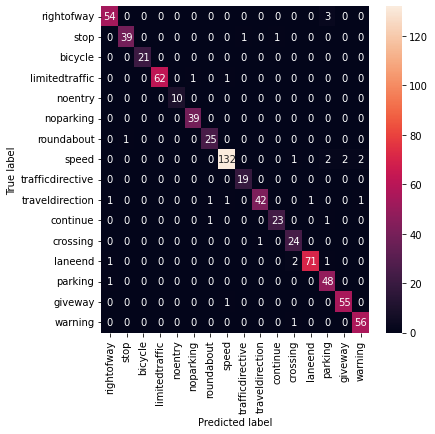


                  precision    recall  f1-score   support

      rightofway       0.95      0.95      0.95        57
            stop       0.97      0.95      0.96        41
         bicycle       1.00      1.00      1.00        21
  limitedtraffic       1.00      0.97      0.98        64
         noentry       1.00      1.00      1.00        10
       noparking       0.97      1.00      0.99        39
      roundabout       0.93      0.96      0.94        26
           speed       0.98      0.95      0.96       139
trafficdirective       0.95      1.00      0.97        19
 traveldirection       0.98      0.89      0.93        47
        continue       0.96      0.92      0.94        25
        crossing       0.86      0.96      0.91        25
         laneend       0.99      0.95      0.97        75
         parking       0.87      0.98      0.92        49
         giveway       0.96      0.98      0.97        56
         warning       0.95      0.98      0.97        57

        acc

In [152]:
print_test_evaluation(sign_MLP_tuned, test_set_1_sign, target_names_sign)

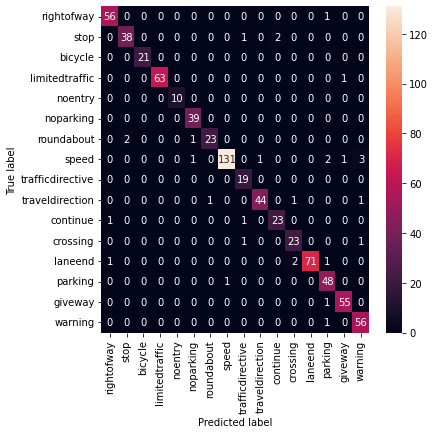


                  precision    recall  f1-score   support

      rightofway       0.97      0.98      0.97        57
            stop       0.95      0.93      0.94        41
         bicycle       1.00      1.00      1.00        21
  limitedtraffic       1.00      0.98      0.99        64
         noentry       1.00      1.00      1.00        10
       noparking       0.95      1.00      0.97        39
      roundabout       0.96      0.88      0.92        26
           speed       0.99      0.94      0.97       139
trafficdirective       0.86      1.00      0.93        19
 traveldirection       0.98      0.94      0.96        47
        continue       0.92      0.92      0.92        25
        crossing       0.88      0.92      0.90        25
         laneend       1.00      0.95      0.97        75
         parking       0.89      0.98      0.93        49
         giveway       0.96      0.98      0.97        56
         warning       0.92      0.98      0.95        57

        acc

In [153]:
print_test_evaluation(sign_MLP_tuned_augmented, test_set_1_sign, target_names_sign)

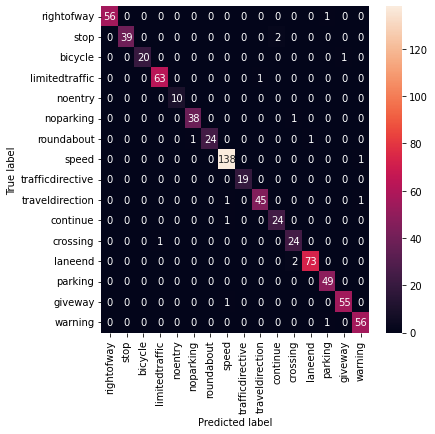


                  precision    recall  f1-score   support

      rightofway       1.00      0.98      0.99        57
            stop       1.00      0.95      0.97        41
         bicycle       1.00      0.95      0.98        21
  limitedtraffic       0.98      0.98      0.98        64
         noentry       1.00      1.00      1.00        10
       noparking       0.97      0.97      0.97        39
      roundabout       1.00      0.92      0.96        26
           speed       0.98      0.99      0.99       139
trafficdirective       1.00      1.00      1.00        19
 traveldirection       0.98      0.96      0.97        47
        continue       0.92      0.96      0.94        25
        crossing       0.89      0.96      0.92        25
         laneend       0.99      0.97      0.98        75
         parking       0.96      1.00      0.98        49
         giveway       0.98      0.98      0.98        56
         warning       0.97      0.98      0.97        57

        acc

In [154]:
print_test_evaluation(sign_LeNet_base, test_set_1_sign, target_names_sign)

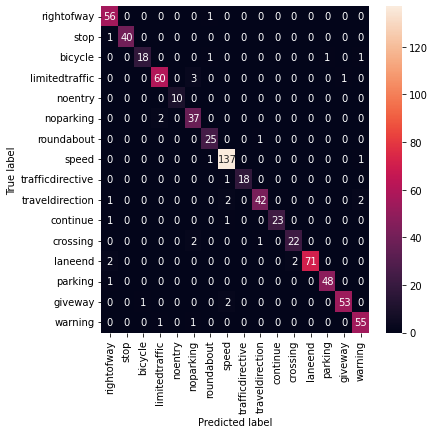


                  precision    recall  f1-score   support

      rightofway       0.90      0.98      0.94        57
            stop       1.00      0.98      0.99        41
         bicycle       0.95      0.86      0.90        21
  limitedtraffic       0.95      0.94      0.94        64
         noentry       1.00      1.00      1.00        10
       noparking       0.86      0.95      0.90        39
      roundabout       0.89      0.96      0.93        26
           speed       0.96      0.99      0.97       139
trafficdirective       1.00      0.95      0.97        19
 traveldirection       0.95      0.89      0.92        47
        continue       1.00      0.92      0.96        25
        crossing       0.92      0.88      0.90        25
         laneend       1.00      0.95      0.97        75
         parking       0.98      0.98      0.98        49
         giveway       0.98      0.95      0.96        56
         warning       0.93      0.96      0.95        57

        acc

In [155]:
print_test_evaluation(sign_VGG_base, test_set_1_sign, target_names_sign)

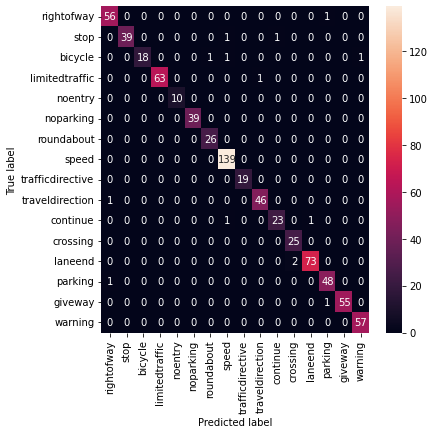


                  precision    recall  f1-score   support

      rightofway       0.97      0.98      0.97        57
            stop       1.00      0.95      0.97        41
         bicycle       1.00      0.86      0.92        21
  limitedtraffic       1.00      0.98      0.99        64
         noentry       1.00      1.00      1.00        10
       noparking       1.00      1.00      1.00        39
      roundabout       0.96      1.00      0.98        26
           speed       0.98      1.00      0.99       139
trafficdirective       1.00      1.00      1.00        19
 traveldirection       0.98      0.98      0.98        47
        continue       0.96      0.92      0.94        25
        crossing       0.93      1.00      0.96        25
         laneend       0.99      0.97      0.98        75
         parking       0.96      0.98      0.97        49
         giveway       1.00      0.98      0.99        56
         warning       0.98      1.00      0.99        57

        acc

In [156]:
print_test_evaluation(sign_VGG_tuneL2_DropOut02, test_set_1_sign, target_names_sign)

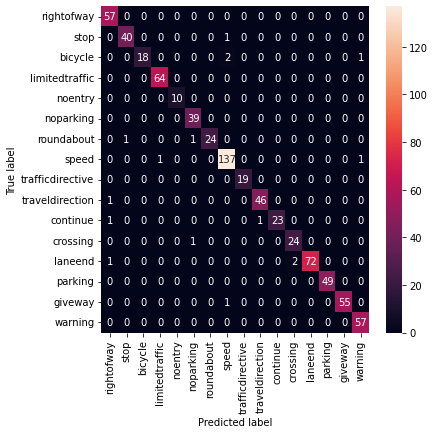


                  precision    recall  f1-score   support

      rightofway       0.95      1.00      0.97        57
            stop       0.98      0.98      0.98        41
         bicycle       1.00      0.86      0.92        21
  limitedtraffic       0.98      1.00      0.99        64
         noentry       1.00      1.00      1.00        10
       noparking       0.95      1.00      0.97        39
      roundabout       1.00      0.92      0.96        26
           speed       0.97      0.99      0.98       139
trafficdirective       1.00      1.00      1.00        19
 traveldirection       0.98      0.98      0.98        47
        continue       1.00      0.92      0.96        25
        crossing       0.92      0.96      0.94        25
         laneend       1.00      0.96      0.98        75
         parking       1.00      1.00      1.00        49
         giveway       1.00      0.98      0.99        56
         warning       0.97      1.00      0.98        57

        acc

In [157]:
print_test_evaluation(sign_VGG_tuneL2_DropOut05, test_set_1_sign, target_names_sign)

### **2.3.2. Test Set 2**

In [158]:
data_independent = file_path_into_dataframe('./independent_data/*/*/*.png')
data_independent.head()  

,image_path,sign_shape,sign_type
0,./independent_data/diamond/warning/0234.png,diamond,warning
1,./independent_data/diamond/warning/0122.png,diamond,warning
2,./independent_data/diamond/warning/0.png,diamond,warning
3,./independent_data/diamond/warning/0100.png,diamond,warning
4,./independent_data/diamond/warning/01002.png,diamond,warning


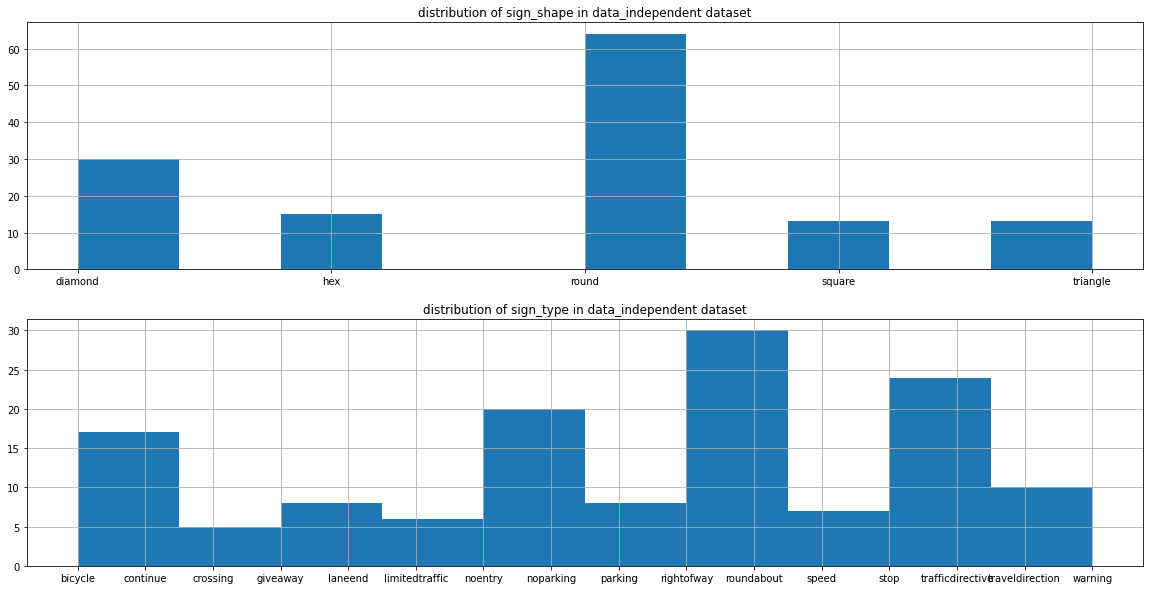

In [159]:
plot_distribution(data_independent, "data_independent")

In [160]:
label_encoder(data_independent)
data_independent.head()

,image_path,sign_shape,sign_type
0,./independent_data/diamond/warning/0234.png,0,15
1,./independent_data/diamond/warning/0122.png,0,15
2,./independent_data/diamond/warning/0.png,0,15
3,./independent_data/diamond/warning/0100.png,0,15
4,./independent_data/diamond/warning/01002.png,0,15


In [161]:
test_set_2_shape = generating_data_from_dataframe(data_independent, "sign_shape", to_grayscale, test = True)
test_set_2_sign = generating_data_from_dataframe(data_independent, "sign_type", to_grayscale, test = True)

Found 135 validated image filenames belonging to 5 classes.
Found 135 validated image filenames belonging to 16 classes.


#### 2.3.2.1 Shape Classification

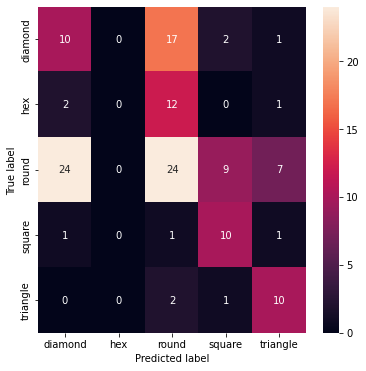


              precision    recall  f1-score   support

     diamond       0.27      0.33      0.30        30
         hex       0.00      0.00      0.00        15
       round       0.43      0.38      0.40        64
      square       0.45      0.77      0.57        13
    triangle       0.50      0.77      0.61        13

    accuracy                           0.40       135
   macro avg       0.33      0.45      0.38       135
weighted avg       0.36      0.40      0.37       135



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [162]:
print_test_evaluation(shape_MLP_base, test_set_2_shape, target_names_shape)

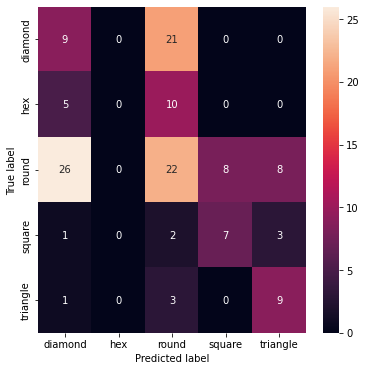


              precision    recall  f1-score   support

     diamond       0.21      0.30      0.25        30
         hex       0.00      0.00      0.00        15
       round       0.38      0.34      0.36        64
      square       0.47      0.54      0.50        13
    triangle       0.45      0.69      0.55        13

    accuracy                           0.35       135
   macro avg       0.30      0.37      0.33       135
weighted avg       0.32      0.35      0.33       135



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [163]:
print_test_evaluation(shape_MLP_tuned, test_set_2_shape, target_names_shape)

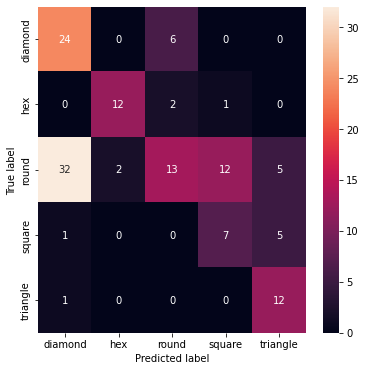


              precision    recall  f1-score   support

     diamond       0.41      0.80      0.55        30
         hex       0.86      0.80      0.83        15
       round       0.62      0.20      0.31        64
      square       0.35      0.54      0.42        13
    triangle       0.55      0.92      0.69        13

    accuracy                           0.50       135
   macro avg       0.56      0.65      0.56       135
weighted avg       0.57      0.50      0.47       135



In [164]:
print_test_evaluation(shape_MLP_tuned_augmented, test_set_2_shape, target_names_shape)

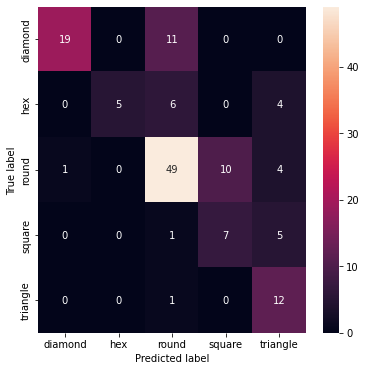


              precision    recall  f1-score   support

     diamond       0.95      0.63      0.76        30
         hex       1.00      0.33      0.50        15
       round       0.72      0.77      0.74        64
      square       0.41      0.54      0.47        13
    triangle       0.48      0.92      0.63        13

    accuracy                           0.68       135
   macro avg       0.71      0.64      0.62       135
weighted avg       0.75      0.68      0.68       135



In [165]:
print_test_evaluation(shape_LeNet_base, test_set_2_shape, target_names_shape)

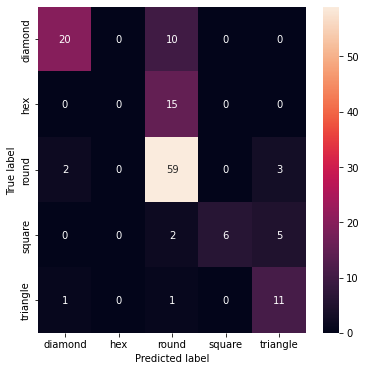


              precision    recall  f1-score   support

     diamond       0.87      0.67      0.75        30
         hex       0.00      0.00      0.00        15
       round       0.68      0.92      0.78        64
      square       1.00      0.46      0.63        13
    triangle       0.58      0.85      0.69        13

    accuracy                           0.71       135
   macro avg       0.63      0.58      0.57       135
weighted avg       0.67      0.71      0.67       135



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [166]:
print_test_evaluation(shape_VGG_base, test_set_2_shape, target_names_shape)

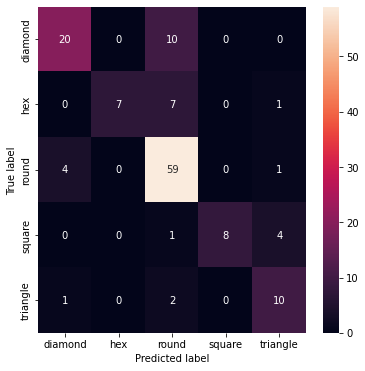


              precision    recall  f1-score   support

     diamond       0.80      0.67      0.73        30
         hex       1.00      0.47      0.64        15
       round       0.75      0.92      0.83        64
      square       1.00      0.62      0.76        13
    triangle       0.62      0.77      0.69        13

    accuracy                           0.77       135
   macro avg       0.83      0.69      0.73       135
weighted avg       0.80      0.77      0.76       135



In [167]:
print_test_evaluation(shape_VGG_tuneL2_DropOut02, test_set_2_shape, target_names_shape)


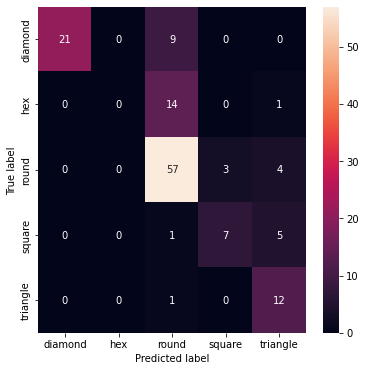


              precision    recall  f1-score   support

     diamond       1.00      0.70      0.82        30
         hex       0.00      0.00      0.00        15
       round       0.70      0.89      0.78        64
      square       0.70      0.54      0.61        13
    triangle       0.55      0.92      0.69        13

    accuracy                           0.72       135
   macro avg       0.59      0.61      0.58       135
weighted avg       0.67      0.72      0.68       135



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [168]:
print_test_evaluation(shape_VGG_tuneL2_DropOut05, test_set_2_shape, target_names_shape)


#### 2.3.1.2 Sign Classification

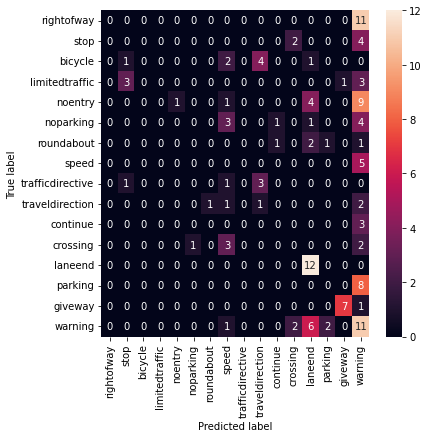


                  precision    recall  f1-score   support

      rightofway       0.00      0.00      0.00        11
            stop       0.00      0.00      0.00         6
         bicycle       0.00      0.00      0.00         8
  limitedtraffic       0.00      0.00      0.00         7
         noentry       1.00      0.07      0.12        15
       noparking       0.00      0.00      0.00         9
      roundabout       0.00      0.00      0.00         5
           speed       0.00      0.00      0.00         5
trafficdirective       0.00      0.00      0.00         5
 traveldirection       0.12      0.20      0.15         5
        continue       0.00      0.00      0.00         3
        crossing       0.00      0.00      0.00         6
         laneend       0.46      1.00      0.63        12
         parking       0.00      0.00      0.00         8
         giveway       0.88      0.88      0.88         8
         warning       0.17      0.50      0.26        22

        acc

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [169]:
print_test_evaluation(sign_MLP_base, test_set_2_sign, target_names_sign)

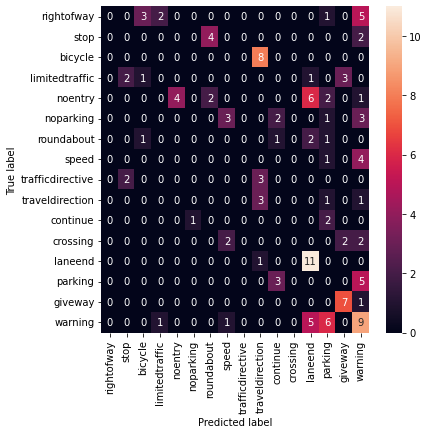


                  precision    recall  f1-score   support

      rightofway       0.00      0.00      0.00        11
            stop       0.00      0.00      0.00         6
         bicycle       0.00      0.00      0.00         8
  limitedtraffic       0.00      0.00      0.00         7
         noentry       1.00      0.27      0.42        15
       noparking       0.00      0.00      0.00         9
      roundabout       0.00      0.00      0.00         5
           speed       0.00      0.00      0.00         5
trafficdirective       0.00      0.00      0.00         5
 traveldirection       0.20      0.60      0.30         5
        continue       0.00      0.00      0.00         3
        crossing       0.00      0.00      0.00         6
         laneend       0.44      0.92      0.59        12
         parking       0.00      0.00      0.00         8
         giveway       0.58      0.88      0.70         8
         warning       0.27      0.41      0.33        22

        acc

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [170]:
print_test_evaluation(sign_MLP_tuned, test_set_2_sign, target_names_sign)

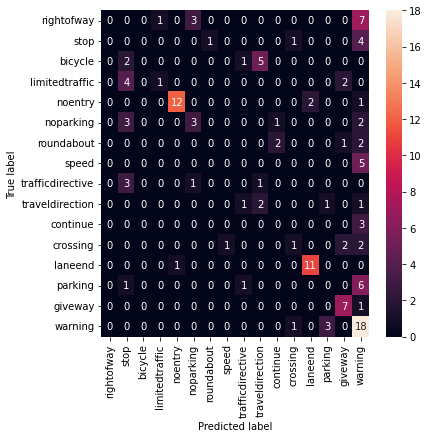


                  precision    recall  f1-score   support

      rightofway       0.00      0.00      0.00        11
            stop       0.00      0.00      0.00         6
         bicycle       0.00      0.00      0.00         8
  limitedtraffic       0.50      0.14      0.22         7
         noentry       0.92      0.80      0.86        15
       noparking       0.43      0.33      0.38         9
      roundabout       0.00      0.00      0.00         5
           speed       0.00      0.00      0.00         5
trafficdirective       0.00      0.00      0.00         5
 traveldirection       0.25      0.40      0.31         5
        continue       0.00      0.00      0.00         3
        crossing       0.33      0.17      0.22         6
         laneend       0.85      0.92      0.88        12
         parking       0.00      0.00      0.00         8
         giveway       0.58      0.88      0.70         8
         warning       0.35      0.82      0.49        22

        acc

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [171]:
print_test_evaluation(sign_MLP_tuned_augmented, test_set_2_sign, target_names_sign)

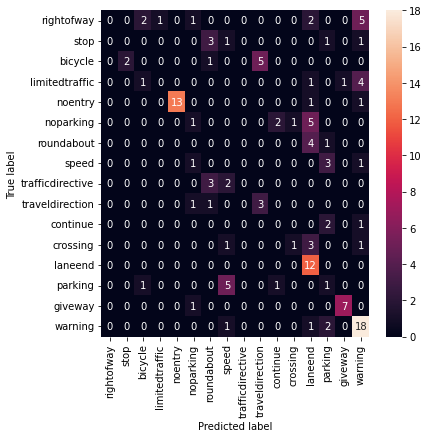


                  precision    recall  f1-score   support

      rightofway       0.00      0.00      0.00        11
            stop       0.00      0.00      0.00         6
         bicycle       0.00      0.00      0.00         8
  limitedtraffic       0.00      0.00      0.00         7
         noentry       1.00      0.87      0.93        15
       noparking       0.20      0.11      0.14         9
      roundabout       0.00      0.00      0.00         5
           speed       0.00      0.00      0.00         5
trafficdirective       0.00      0.00      0.00         5
 traveldirection       0.38      0.60      0.46         5
        continue       0.00      0.00      0.00         3
        crossing       0.50      0.17      0.25         6
         laneend       0.41      1.00      0.59        12
         parking       0.10      0.12      0.11         8
         giveway       0.88      0.88      0.88         8
         warning       0.56      0.82      0.67        22

        acc

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [172]:
print_test_evaluation(sign_LeNet_base, test_set_2_sign, target_names_sign)

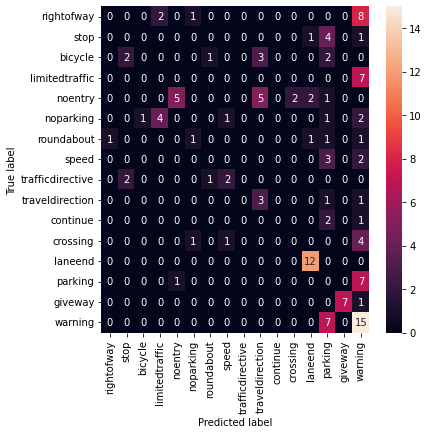


                  precision    recall  f1-score   support

      rightofway       0.00      0.00      0.00        11
            stop       0.00      0.00      0.00         6
         bicycle       0.00      0.00      0.00         8
  limitedtraffic       0.00      0.00      0.00         7
         noentry       0.83      0.33      0.48        15
       noparking       0.00      0.00      0.00         9
      roundabout       0.00      0.00      0.00         5
           speed       0.00      0.00      0.00         5
trafficdirective       0.00      0.00      0.00         5
 traveldirection       0.27      0.60      0.37         5
        continue       0.00      0.00      0.00         3
        crossing       0.00      0.00      0.00         6
         laneend       0.75      1.00      0.86        12
         parking       0.00      0.00      0.00         8
         giveway       1.00      0.88      0.93         8
         warning       0.30      0.68      0.42        22

        acc

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [173]:
print_test_evaluation(sign_VGG_base, test_set_2_sign, target_names_sign)

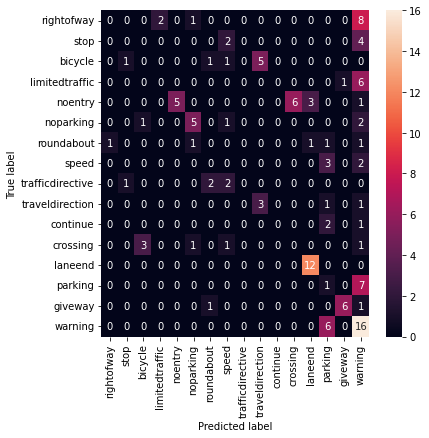


                  precision    recall  f1-score   support

      rightofway       0.00      0.00      0.00        11
            stop       0.00      0.00      0.00         6
         bicycle       0.00      0.00      0.00         8
  limitedtraffic       0.00      0.00      0.00         7
         noentry       1.00      0.33      0.50        15
       noparking       0.62      0.56      0.59         9
      roundabout       0.00      0.00      0.00         5
           speed       0.00      0.00      0.00         5
trafficdirective       0.00      0.00      0.00         5
 traveldirection       0.38      0.60      0.46         5
        continue       0.00      0.00      0.00         3
        crossing       0.00      0.00      0.00         6
         laneend       0.75      1.00      0.86        12
         parking       0.07      0.12      0.09         8
         giveway       0.86      0.75      0.80         8
         warning       0.31      0.73      0.44        22

        acc

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [174]:
print_test_evaluation(sign_VGG_tuneL2_DropOut02, test_set_2_sign, target_names_sign)

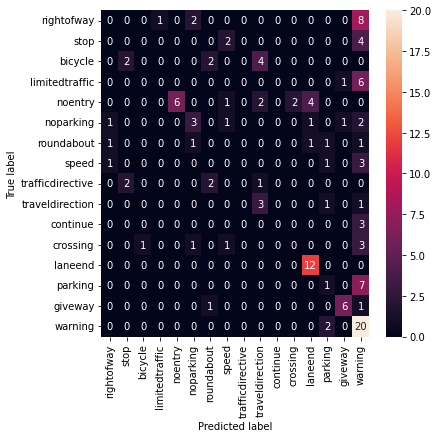


                  precision    recall  f1-score   support

      rightofway       0.00      0.00      0.00        11
            stop       0.00      0.00      0.00         6
         bicycle       0.00      0.00      0.00         8
  limitedtraffic       0.00      0.00      0.00         7
         noentry       1.00      0.40      0.57        15
       noparking       0.43      0.33      0.38         9
      roundabout       0.00      0.00      0.00         5
           speed       0.00      0.00      0.00         5
trafficdirective       0.00      0.00      0.00         5
 traveldirection       0.30      0.60      0.40         5
        continue       0.00      0.00      0.00         3
        crossing       0.00      0.00      0.00         6
         laneend       0.67      1.00      0.80        12
         parking       0.17      0.12      0.14         8
         giveway       0.75      0.75      0.75         8
         warning       0.34      0.91      0.49        22

        acc

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [175]:
print_test_evaluation(sign_VGG_tuneL2_DropOut05, test_set_2_sign, target_names_sign)

https://keras.io/guides/keras_tuner/getting_started/

https://keras.io/keras_tuner/

https://keras.io/guides/keras_tuner/visualize_tuning/

https://www.tensorflow.org/tutorials/keras/keras_tuner

Hoang check links for documentation on tuner